# 04 - Basic Modeling for Car Price Prediction

This notebook establishes baseline models for predicting car prices:
- Linear Regression (baseline)
- LightGBM Regressor

Key approach:
- Feature engineering applied correctly (fit on train only)
- Log-transform target for training
- Evaluate on original euro prices

## 1. Imports and Setup

In [1]:
# Core libraries
import polars as pl
import numpy as np
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# LightGBM
from lightgbm import LGBMRegressor

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Path handling
from pathlib import Path
import os
import sys

# Add project root to path
current_dir = Path.cwd()
project_root = current_dir.parent if current_dir.name == "notebooks" else current_dir
sys.path.insert(0, str(project_root))

# Project imports
from src.config import DATA_PATH, MODELS_PATH
from src import data_processing
from src.features import CarPriceFeatureEngineer

# Configuration
RANDOM_STATE = 42
TEST_SIZE = 0.2

plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)

print("Setup complete")

Setup complete


## 2. Load Cleaned Data

In [2]:
# Load and clean data
data_dir = Path(os.path.join(DATA_PATH, "le_boncoin_13_oct_2025"))
df_raw = data_processing.load_car_data(data_dir)
df_clean = data_processing.clean_car_data(df_raw)

print(f"Dataset shape: {df_clean.shape}")
print(f"Columns: {df_clean.columns}")
df_clean.head()

(732427, 35)
🧹 Starting data cleaning pipeline...

1️⃣ Converting data types...
   Original: 732,427 rows
   After conversion: 732,426 rows
   Removed (invalid price): 1

2️⃣ Filtering and grouping brands...
   Removed 63 brands with <50 cars
   Original: 732,427 rows
   After conversion: 732,426 rows
   Removed (invalid price): 1

2️⃣ Filtering and grouping brands...
   Removed 63 brands with <50 cars
   Grouped 38 brands into price tiers

3️⃣ Removing antique cars (pre-1990)...
   Removed 14,075 antique cars

4️⃣ Removing 'autre' entries...
   Removed 4,050 'autre' entries

5️⃣ Removing outliers (IQR 1.5× for price, 1.5× for km)...
   Before: 713,413 rows
   After: 691,115 rows
   Removed: 22,298 (3.1%)

✅ Data cleaning completed!
Final dataset: 691,115 rows × 5 columns
Dataset shape: (691115, 5)
Columns: ['price', 'year', 'km', 'brand', 'model']
   Grouped 38 brands into price tiers

3️⃣ Removing antique cars (pre-1990)...
   Removed 14,075 antique cars

4️⃣ Removing 'autre' entries

price,year,km,brand,model
f64,f64,f64,str,str
22990.0,2019.0,87000.0,"""other_luxury""","""other_luxury"""
17000.0,2023.0,36000.0,"""other_luxury""","""other_luxury"""
194900.0,2025.0,300.0,"""other_luxury""","""other_luxury"""
41990.0,2019.0,24200.0,"""other_luxury""","""other_luxury"""
229900.0,2024.0,193.0,"""other_luxury""","""other_luxury"""


## 3. Define Target and Features

In [3]:
TARGET = 'price'
FEATURES = ['year', 'km', 'brand', 'model']

# Prepare X and y
X = df_clean.select(FEATURES)
y = df_clean[TARGET].to_numpy()

# Train-test split
# Convert to pandas for sklearn compatibility in split
X_pd = X.to_pandas()

X_train_pd, X_test_pd, y_train, y_test = train_test_split(
    X_pd, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    shuffle=True
)

# Convert back to polars for feature engineering
X_train = pl.from_pandas(X_train_pd)
X_test = pl.from_pandas(X_test_pd)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

Training set: 552,892 samples
Test set: 138,223 samples


## 4. Apply Feature Engineering

In [4]:
# Initialize feature engineer
fe = CarPriceFeatureEngineer(
    current_year=2025,
    add_log_features=True,
    add_polynomial_features=True,
    add_target_encoding=True,
    add_categorical_features=False,  # Skip string categoricals for now
    add_interaction_features=True
)

# Fit ONLY on training data
fe.fit(X_train, y_train)

# Transform both sets
X_train_fe = fe.transform(X_train)
X_test_fe = fe.transform(X_test)

print(f"Features after engineering: {X_train_fe.shape[1]}")

Features after engineering: 29


In [5]:
# Drop raw categorical columns (brand, model) - aggregates capture their info
# Also drop 'year' since we have car_age and decade
COLS_TO_DROP = ['brand', 'model', 'year']

X_train_final = X_train_fe.drop(COLS_TO_DROP)
X_test_final = X_test_fe.drop(COLS_TO_DROP)

# Convert to pandas for sklearn
X_train_final_pd = X_train_final.to_pandas()
X_test_final_pd = X_test_final.to_pandas()

print(f"Final feature columns ({len(X_train_final_pd.columns)}):")
for col in X_train_final_pd.columns:
    print(f"  - {col}")

FINAL_FEATURES = X_train_final_pd.columns.tolist()
# Store features for later use

Final feature columns (26):
  - km
  - car_age
  - decade
  - is_almost_new
  - km_per_year
  - is_low_mileage
  - is_high_mileage
  - is_nearly_new_mileage
  - log_km
  - log_km_per_year
  - sqrt_km
  - car_age_squared
  - brand_count
  - brand_avg_km
  - brand_avg_age
  - brand_avg_price
  - brand_median_price
  - brand_price_std
  - model_count
  - model_popularity_ratio
  - model_avg_price
  - model_median_price
  - age_km_interaction
  - is_low_use_recent
  - is_high_use_new
  - is_garage_queen


## 5. Log-Transform Target

In [11]:
# Log-transform target for training (helps with skewed price distribution)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

print(f"Price range (euros): {y_train.min():,.0f} - {y_train.max():,.0f}")
print(f"Log price range: {y_train_log.min():.2f} - {y_train_log.max():.2f}")

Price range (euros): 200 - 750,000
Log price range: 5.30 - 13.53


## 6. Train Models

In [12]:
# A. Linear Regression baseline
model_lr = LinearRegression()
model_lr.fit(X_train_final_pd, y_train_log)

# Predict and convert back to euros
y_pred_log_lr = model_lr.predict(X_test_final_pd)
y_pred_lr = np.expm1(y_pred_log_lr)

print("Linear Regression trained")

Linear Regression trained


In [13]:
# B. LightGBM Regressor
model_lgb = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    num_leaves=31,
    random_state=RANDOM_STATE,
    verbose=-1
)

model_lgb.fit(X_train_final_pd, y_train_log)

# Predict and convert back to euros
y_pred_log_lgb = model_lgb.predict(X_test_final_pd)
y_pred_lgb = np.expm1(y_pred_log_lgb)

print("LightGBM trained")

LightGBM trained


## 7. Evaluation

In [14]:
def evaluate_model(y_true, y_pred, model_name):
    """Calculate and return evaluation metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'Model': model_name,
        'MAE (euros)': mae,
        'RMSE (euros)': rmse,
        'R2': r2,
        'MAPE (%)': mape
    }

In [15]:
# Evaluate both models
results_lr = evaluate_model(y_test, y_pred_lr, 'Linear Regression')
results_lgb = evaluate_model(y_test, y_pred_lgb, 'LightGBM')

# Create comparison table (keep numeric for plotting)
results_df = pd.DataFrame([results_lr, results_lgb])

# Display formatted version
display_df = results_df.copy()
display_df['MAE (euros)'] = display_df['MAE (euros)'].apply(lambda x: f"{x:,.0f}")
display_df['RMSE (euros)'] = display_df['RMSE (euros)'].apply(lambda x: f"{x:,.0f}")
display_df['R2'] = display_df['R2'].apply(lambda x: f"{x:.4f}")
display_df['MAPE (%)'] = display_df['MAPE (%)'].apply(lambda x: f"{x:.2f}")

print("Model Comparison")
print("=" * 70)
print(display_df.to_string(index=False))

# Calculate improvement
mae_improvement = (results_lr['MAE (euros)'] - results_lgb['MAE (euros)']) / results_lr['MAE (euros)'] * 100
r2_improvement = results_lgb['R2'] - results_lr['R2']
print(f"\nLightGBM vs Linear Regression:")
print(f"  MAE improvement: {mae_improvement:.1f}%")
print(f"  R2 improvement: {r2_improvement:.4f}")

Model Comparison
            Model MAE (euros) RMSE (euros)            R2 MAPE (%)
Linear Regression     213,495   29,462,936 -2110666.9507    64.00
         LightGBM       2,884        7,899        0.8483    17.67

LightGBM vs Linear Regression:
  MAE improvement: 98.6%
  R2 improvement: 2110667.7990


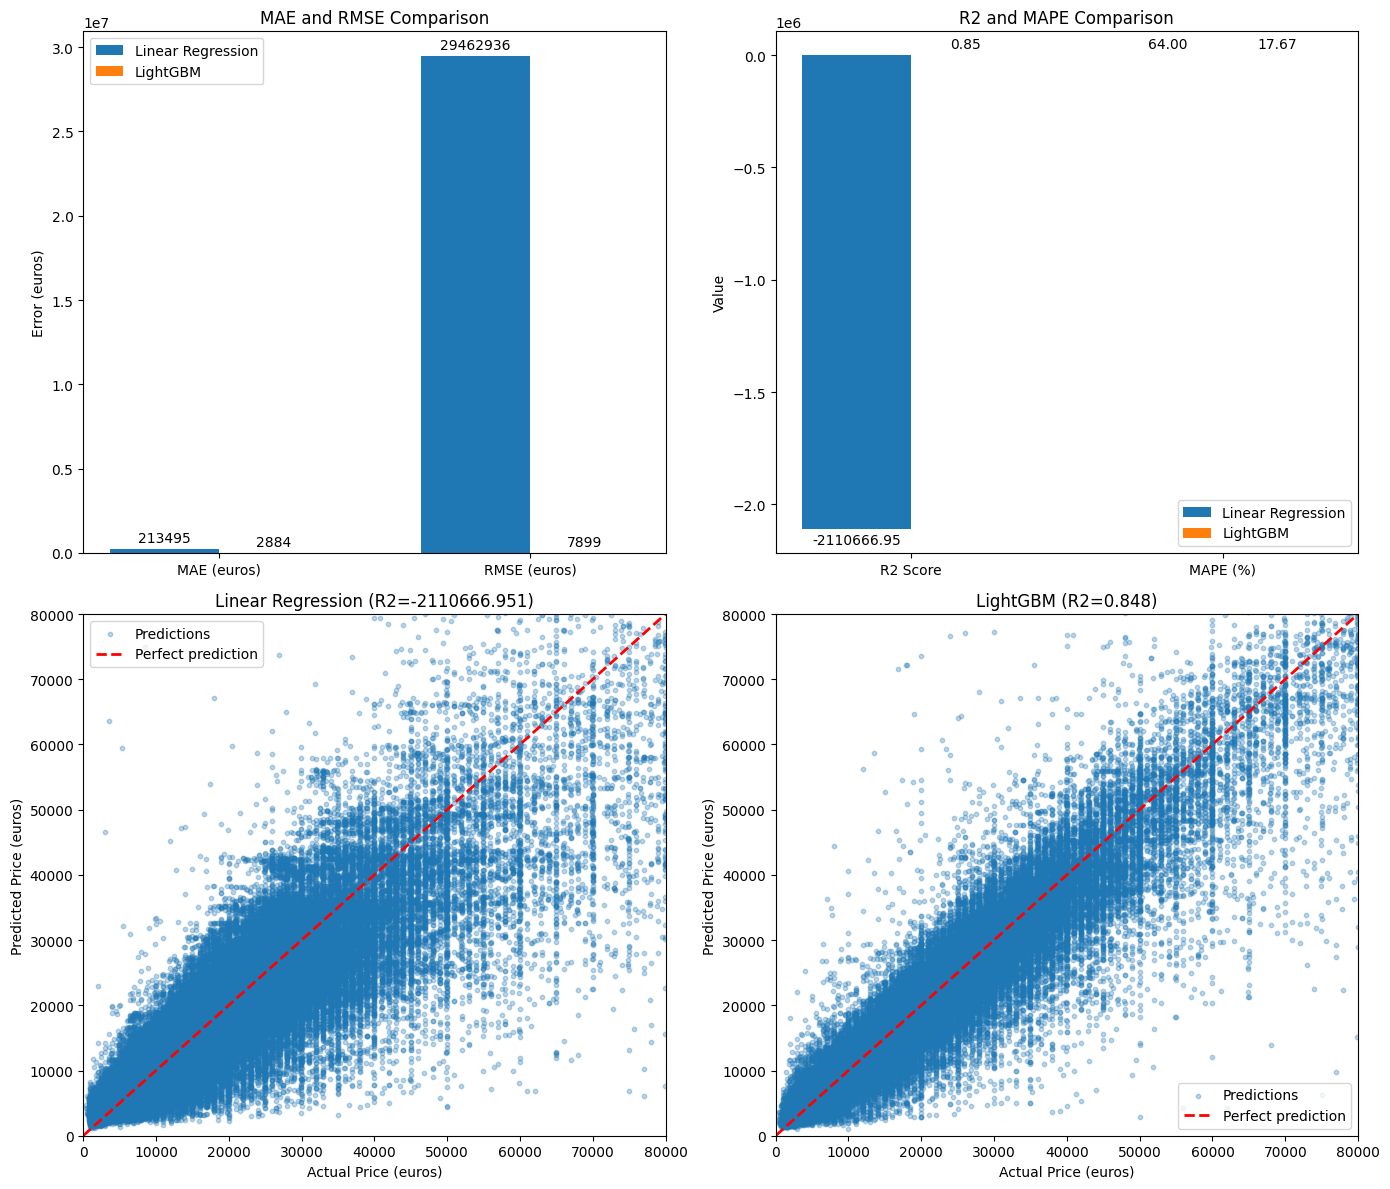

In [16]:
# Visual comparison of both models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Metrics bar chart comparison
ax1 = axes[0, 0]
metrics = ['MAE (euros)', 'RMSE (euros)']
x = np.arange(len(metrics))
width = 0.35
bars1 = ax1.bar(x - width/2, [results_lr['MAE (euros)'], results_lr['RMSE (euros)']], width, label='Linear Regression')
bars2 = ax1.bar(x + width/2, [results_lgb['MAE (euros)'], results_lgb['RMSE (euros)']], width, label='LightGBM')
ax1.set_ylabel('Error (euros)')
ax1.set_title('MAE and RMSE Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.bar_label(bars1, fmt='%.0f', padding=3)
ax1.bar_label(bars2, fmt='%.0f', padding=3)

# Plot 2: R2 and MAPE comparison
ax2 = axes[0, 1]
metrics2 = ['R2 Score', 'MAPE (%)']
bars3 = ax2.bar(x - width/2, [results_lr['R2'], results_lr['MAPE (%)']], width, label='Linear Regression')
bars4 = ax2.bar(x + width/2, [results_lgb['R2'], results_lgb['MAPE (%)']], width, label='LightGBM')
ax2.set_ylabel('Value')
ax2.set_title('R2 and MAPE Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics2)
ax2.legend()
ax2.bar_label(bars3, fmt='%.2f', padding=3)
ax2.bar_label(bars4, fmt='%.2f', padding=3)

# Plot 3: Predicted vs Actual - Linear Regression
ax3 = axes[1, 0]
ax3.scatter(y_test, y_pred_lr, alpha=0.3, s=10, label='Predictions')
max_val = 80000
ax3.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect prediction')
ax3.set_xlabel('Actual Price (euros)')
ax3.set_ylabel('Predicted Price (euros)')
ax3.set_title(f'Linear Regression (R2={results_lr["R2"]:.3f})')
ax3.set_xlim(0, max_val)
ax3.set_ylim(0, max_val)
ax3.legend()

# Plot 4: Predicted vs Actual - LightGBM
ax4 = axes[1, 1]
ax4.scatter(y_test, y_pred_lgb, alpha=0.3, s=10, label='Predictions')
ax4.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect prediction')
ax4.set_xlabel('Actual Price (euros)')
ax4.set_ylabel('Predicted Price (euros)')
ax4.set_title(f'LightGBM (R2={results_lgb["R2"]:.3f})')
ax4.set_xlim(0, max_val)
ax4.set_ylim(0, max_val)
ax4.legend()

plt.tight_layout()
plt.show()

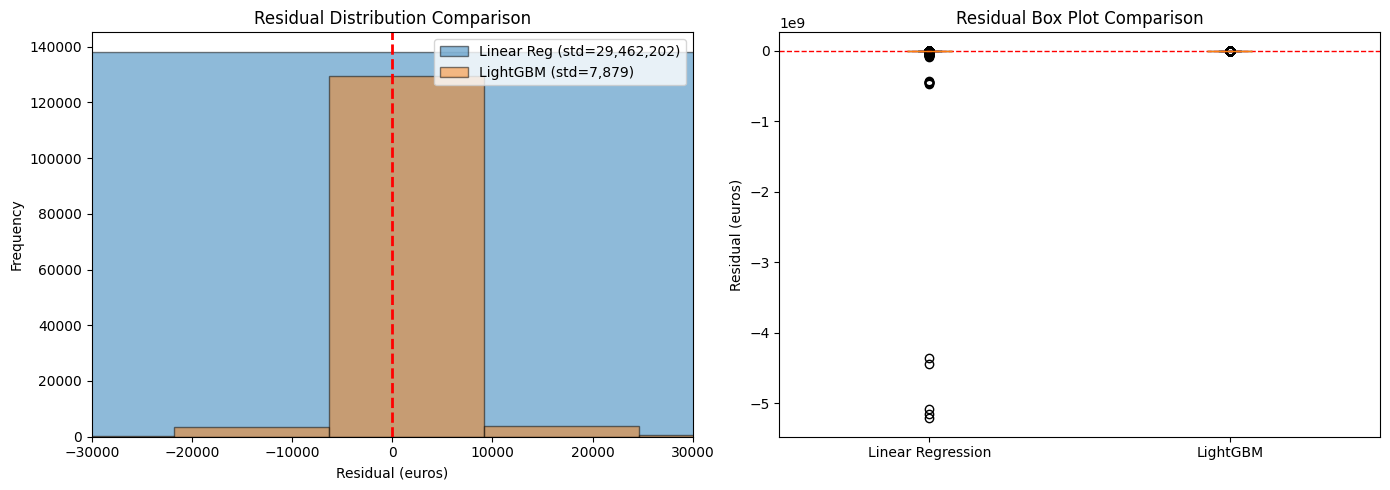

Residual Statistics:
  Linear Regression - Mean: -207,943, Std: 29,462,202
  LightGBM          - Mean: 559, Std: 7,879


In [17]:
# Residual distribution comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

residuals_lr = y_test - y_pred_lr
residuals_lgb = y_test - y_pred_lgb

# Histogram comparison
ax1 = axes[0]
ax1.hist(residuals_lr, bins=50, alpha=0.5, label=f'Linear Reg (std={np.std(residuals_lr):,.0f})', edgecolor='black')
ax1.hist(residuals_lgb, bins=50, alpha=0.5, label=f'LightGBM (std={np.std(residuals_lgb):,.0f})', edgecolor='black')
ax1.axvline(x=0, color='red', linestyle='--', lw=2)
ax1.set_xlabel('Residual (euros)')
ax1.set_ylabel('Frequency')
ax1.set_title('Residual Distribution Comparison')
ax1.legend()
ax1.set_xlim(-30000, 30000)

# Box plot comparison
ax2 = axes[1]
bp = ax2.boxplot([residuals_lr, residuals_lgb], labels=['Linear Regression', 'LightGBM'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightgreen')
ax2.axhline(y=0, color='red', linestyle='--', lw=1)
ax2.set_ylabel('Residual (euros)')
ax2.set_title('Residual Box Plot Comparison')

plt.tight_layout()
plt.show()

print("Residual Statistics:")
print(f"  Linear Regression - Mean: {np.mean(residuals_lr):,.0f}, Std: {np.std(residuals_lr):,.0f}")
print(f"  LightGBM          - Mean: {np.mean(residuals_lgb):,.0f}, Std: {np.std(residuals_lgb):,.0f}")

## 8. Diagnostic Plots

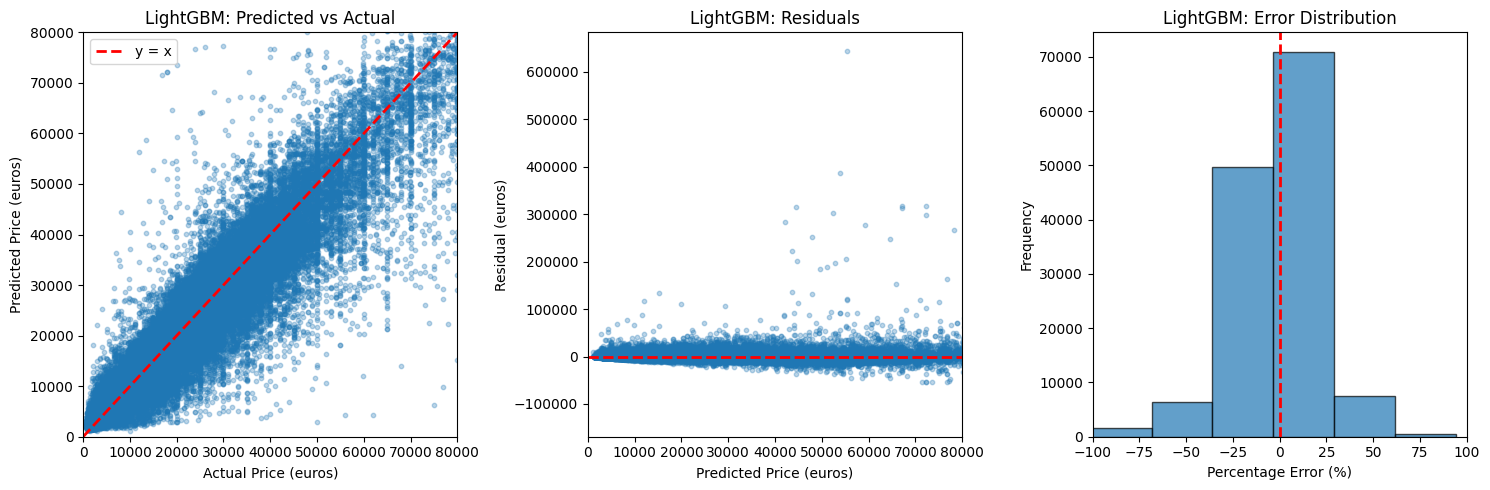


Error Statistics (LightGBM):
  Median absolute error: 1,537 euros
  90th percentile abs error: 5,858 euros
  Median percentage error: 11.9%


In [18]:
# Select the better model for diagnostics (LightGBM expected)
y_pred_best = y_pred_lgb
model_name_best = "LightGBM"

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Predicted vs Actual
ax1 = axes[0]
ax1.scatter(y_test, y_pred_best, alpha=0.3, s=10)
max_val = max(y_test.max(), y_pred_best.max())
ax1.plot([0, max_val], [0, max_val], 'r--', lw=2, label='y = x')
ax1.set_xlabel('Actual Price (euros)')
ax1.set_ylabel('Predicted Price (euros)')
ax1.set_title(f'{model_name_best}: Predicted vs Actual')
ax1.legend()
ax1.set_xlim(0, 80000)
ax1.set_ylim(0, 80000)

# Plot 2: Residuals
ax2 = axes[1]
residuals = y_test - y_pred_best
ax2.scatter(y_pred_best, residuals, alpha=0.3, s=10)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Price (euros)')
ax2.set_ylabel('Residual (euros)')
ax2.set_title(f'{model_name_best}: Residuals')
ax2.set_xlim(0, 80000)

# Plot 3: Percentage Error Distribution
ax3 = axes[2]
pct_error = ((y_test - y_pred_best) / y_test) * 100
ax3.hist(pct_error, bins=50, edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Percentage Error (%)')
ax3.set_ylabel('Frequency')
ax3.set_title(f'{model_name_best}: Error Distribution')
ax3.set_xlim(-100, 100)

plt.tight_layout()
plt.show()

# Summary statistics for errors
print(f"\nError Statistics ({model_name_best}):")
print(f"  Median absolute error: {np.median(np.abs(residuals)):,.0f} euros")
print(f"  90th percentile abs error: {np.percentile(np.abs(residuals), 90):,.0f} euros")
print(f"  Median percentage error: {np.median(np.abs(pct_error)):.1f}%")

## 9. Feature Importance (LightGBM)

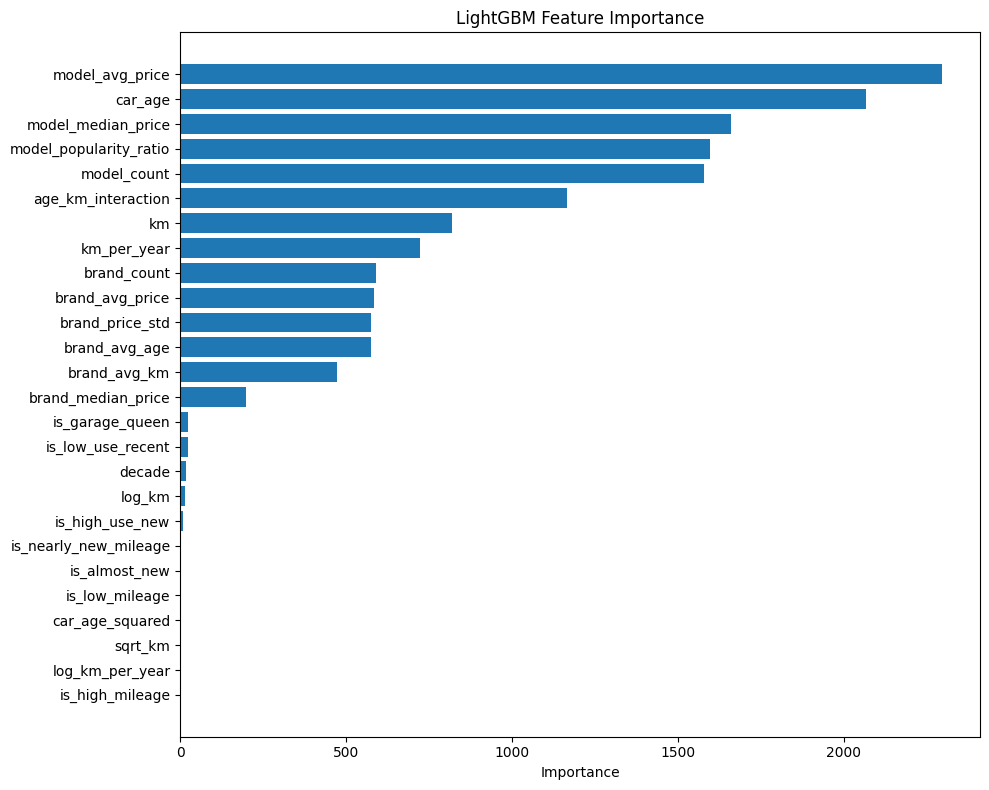

Top 10 Features:
               feature  importance
       model_avg_price        2296
               car_age        2067
    model_median_price        1661
model_popularity_ratio        1596
           model_count        1579
    age_km_interaction        1167
                    km         820
           km_per_year         724
           brand_count         590
       brand_avg_price         585


In [19]:
# Feature importance from LightGBM
importance_df = pd.DataFrame({
    'feature': X_train_final_pd.columns,
    'importance': model_lgb.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('LightGBM Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 10 Features:")
print(importance_df.head(10).to_string(index=False))

## 10. Per-Brand Error Analysis

Understanding how well the model performs across different brands helps identify where the model struggles.

In [20]:
# Create analysis dataframe with brand info
analysis_df = pd.DataFrame({
    'brand': X_test_pd['brand'].values,
    'actual': y_test,
    'pred_lr': y_pred_lr,
    'pred_lgb': y_pred_lgb
})

# Calculate per-brand metrics for LightGBM
brand_metrics = []
for brand in analysis_df['brand'].unique():
    brand_data = analysis_df[analysis_df['brand'] == brand]
    n_samples = len(brand_data)
    
    if n_samples >= 10:  # Only brands with enough samples
        mae = mean_absolute_error(brand_data['actual'], brand_data['pred_lgb'])
        mape = np.mean(np.abs((brand_data['actual'] - brand_data['pred_lgb']) / brand_data['actual'])) * 100
        r2 = r2_score(brand_data['actual'], brand_data['pred_lgb']) if n_samples > 1 else np.nan
        avg_price = brand_data['actual'].mean()
        
        brand_metrics.append({
            'brand': brand,
            'n_samples': n_samples,
            'avg_price': avg_price,
            'MAE': mae,
            'MAPE': mape,
            'R2': r2
        })

brand_metrics_df = pd.DataFrame(brand_metrics).sort_values('n_samples', ascending=False)

print("Per-Brand Performance (LightGBM) - Top 20 brands by sample size:")
print("=" * 90)
display_brand = brand_metrics_df.head(20).copy()
display_brand['avg_price'] = display_brand['avg_price'].apply(lambda x: f"{x:,.0f}")
display_brand['MAE'] = display_brand['MAE'].apply(lambda x: f"{x:,.0f}")
display_brand['MAPE'] = display_brand['MAPE'].apply(lambda x: f"{x:.1f}%")
display_brand['R2'] = display_brand['R2'].apply(lambda x: f"{x:.3f}" if pd.notna(x) else "N/A")
print(display_brand.to_string(index=False))

Per-Brand Performance (LightGBM) - Top 20 brands by sample size:
        brand  n_samples avg_price    MAE  MAPE    R2
      PEUGEOT      21294    13,055  1,855 17.9% 0.899
      RENAULT      18617    13,027  1,803 18.1% 0.875
      CITROEN      11837    10,347  1,429 17.5% 0.909
   VOLKSWAGEN      10719    19,401  2,919 18.0% 0.882
          BMW       9392    24,466  4,104 20.0% 0.872
         AUDI       8440    25,568  3,305 14.2% 0.913
MERCEDES-BENZ       8208    28,461  4,618 17.7% 0.842
         FORD       5507    17,177  2,703 19.2% 0.846
         OPEL       3872    11,064  1,591 21.1% 0.900
       TOYOTA       3484    20,545  2,376 12.8% 0.855
        DACIA       3481    14,611  1,442 11.4% 0.908
         FIAT       3342    11,462  1,825 17.3% 0.832
       NISSAN       3122    14,856  1,745 14.3% 0.914
         MINI       2893    15,521  2,448 18.8% 0.855
      PORSCHE       2007    71,592 11,980 16.5% 0.852
         SEAT       1988    13,560  2,195 20.4% 0.828
      HYUNDAI    

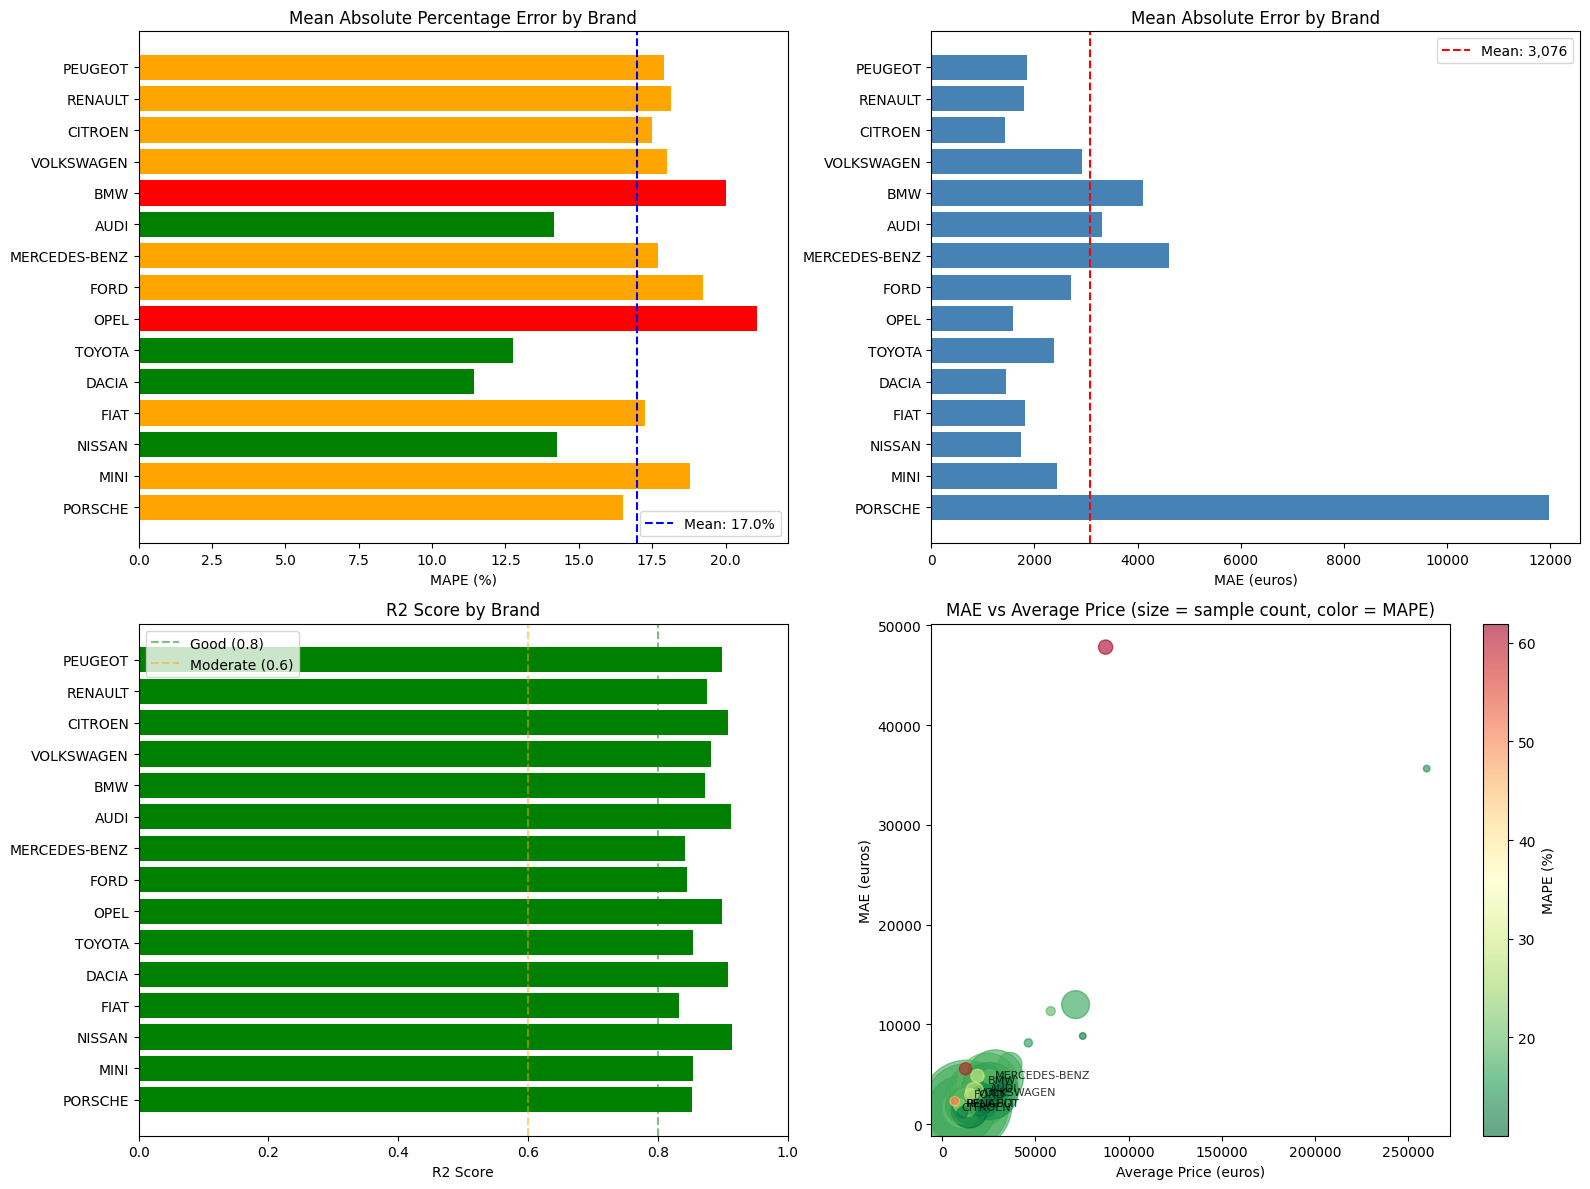

In [21]:
# Visualize per-brand performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Get top 15 brands by sample size for visualization
top_brands = brand_metrics_df.head(15)

# Plot 1: MAPE by brand
ax1 = axes[0, 0]
colors = ['green' if x < 15 else 'orange' if x < 20 else 'red' for x in top_brands['MAPE']]
bars = ax1.barh(top_brands['brand'], top_brands['MAPE'], color=colors)
ax1.axvline(x=top_brands['MAPE'].mean(), color='blue', linestyle='--', label=f'Mean: {top_brands["MAPE"].mean():.1f}%')
ax1.set_xlabel('MAPE (%)')
ax1.set_title('Mean Absolute Percentage Error by Brand')
ax1.legend()
ax1.invert_yaxis()

# Plot 2: MAE by brand
ax2 = axes[0, 1]
ax2.barh(top_brands['brand'], top_brands['MAE'], color='steelblue')
ax2.axvline(x=top_brands['MAE'].mean(), color='red', linestyle='--', label=f'Mean: {top_brands["MAE"].mean():,.0f}')
ax2.set_xlabel('MAE (euros)')
ax2.set_title('Mean Absolute Error by Brand')
ax2.legend()
ax2.invert_yaxis()

# Plot 3: R2 by brand
ax3 = axes[1, 0]
r2_colors = ['green' if x > 0.8 else 'orange' if x > 0.6 else 'red' for x in top_brands['R2']]
ax3.barh(top_brands['brand'], top_brands['R2'], color=r2_colors)
ax3.axvline(x=0.8, color='green', linestyle='--', alpha=0.5, label='Good (0.8)')
ax3.axvline(x=0.6, color='orange', linestyle='--', alpha=0.5, label='Moderate (0.6)')
ax3.set_xlabel('R2 Score')
ax3.set_title('R2 Score by Brand')
ax3.set_xlim(0, 1)
ax3.legend()
ax3.invert_yaxis()

# Plot 4: MAE vs Average Price (scatter)
ax4 = axes[1, 1]
scatter = ax4.scatter(brand_metrics_df['avg_price'], brand_metrics_df['MAE'], 
                       s=brand_metrics_df['n_samples']/5, alpha=0.6, c=brand_metrics_df['MAPE'], cmap='RdYlGn_r')
ax4.set_xlabel('Average Price (euros)')
ax4.set_ylabel('MAE (euros)')
ax4.set_title('MAE vs Average Price (size = sample count, color = MAPE)')
plt.colorbar(scatter, ax=ax4, label='MAPE (%)')

# Add annotations for some brands
for idx, row in brand_metrics_df.head(8).iterrows():
    ax4.annotate(row['brand'], (row['avg_price'], row['MAE']), fontsize=8, alpha=0.8)

plt.tight_layout()
plt.show()

In [22]:
# Best and worst performing brands
print("Best Performing Brands (lowest MAPE):")
print("-" * 50)
best = brand_metrics_df.nsmallest(5, 'MAPE')[['brand', 'n_samples', 'MAPE', 'R2', 'avg_price']]
for _, row in best.iterrows():
    print(f"  {row['brand']:15} | MAPE: {row['MAPE']:5.1f}% | R2: {row['R2']:.3f} | Avg: {row['avg_price']:>8,.0f} EUR | n={row['n_samples']}")

print("\nWorst Performing Brands (highest MAPE, n >= 50):")
print("-" * 50)
worst = brand_metrics_df[brand_metrics_df['n_samples'] >= 50].nlargest(5, 'MAPE')[['brand', 'n_samples', 'MAPE', 'R2', 'avg_price']]
for _, row in worst.iterrows():
    print(f"  {row['brand']:15} | MAPE: {row['MAPE']:5.1f}% | R2: {row['R2']:.3f} | Avg: {row['avg_price']:>8,.0f} EUR | n={row['n_samples']}")

Best Performing Brands (lowest MAPE):
--------------------------------------------------
  TESLA           | MAPE:  10.0% | R2: 0.606 | Avg:   30,323 EUR | n=495
  MG/MG MOTOR     | MAPE:  10.0% | R2: 0.728 | Avg:   22,262 EUR | n=550
  ALPINE          | MAPE:  10.9% | R2: 0.594 | Avg:   75,422 EUR | n=114
  ABARTH          | MAPE:  11.2% | R2: 0.859 | Avg:   18,615 EUR | n=225
  DACIA           | MAPE:  11.4% | R2: 0.908 | Avg:   14,611 EUR | n=3481

Worst Performing Brands (highest MAPE, n >= 50):
--------------------------------------------------
  other_luxury    | MAPE:  61.9% | R2: 0.121 | Avg:   87,679 EUR | n=526
  other_standard  | MAPE:  58.8% | R2: 0.201 | Avg:   12,580 EUR | n=388
  CHRYSLER        | MAPE:  51.1% | R2: 0.623 | Avg:    6,913 EUR | n=113
  other_low_cost  | MAPE:  44.5% | R2: 0.268 | Avg:    6,842 EUR | n=231
  CHEVROLET       | MAPE:  30.5% | R2: 0.814 | Avg:   18,975 EUR | n=453


## 11. Additional Regression Diagnostics

**Note on AUC/ROC:** These metrics are for **classification** problems (predicting categories), not regression (predicting continuous values like price). For regression, we use:
- **R2**: How much variance is explained (1.0 = perfect)
- **MAE/RMSE**: Error magnitude in the same units as target
- **MAPE**: Percentage error (intuitive interpretation)
- **Residual analysis**: Check for patterns/heteroscedasticity

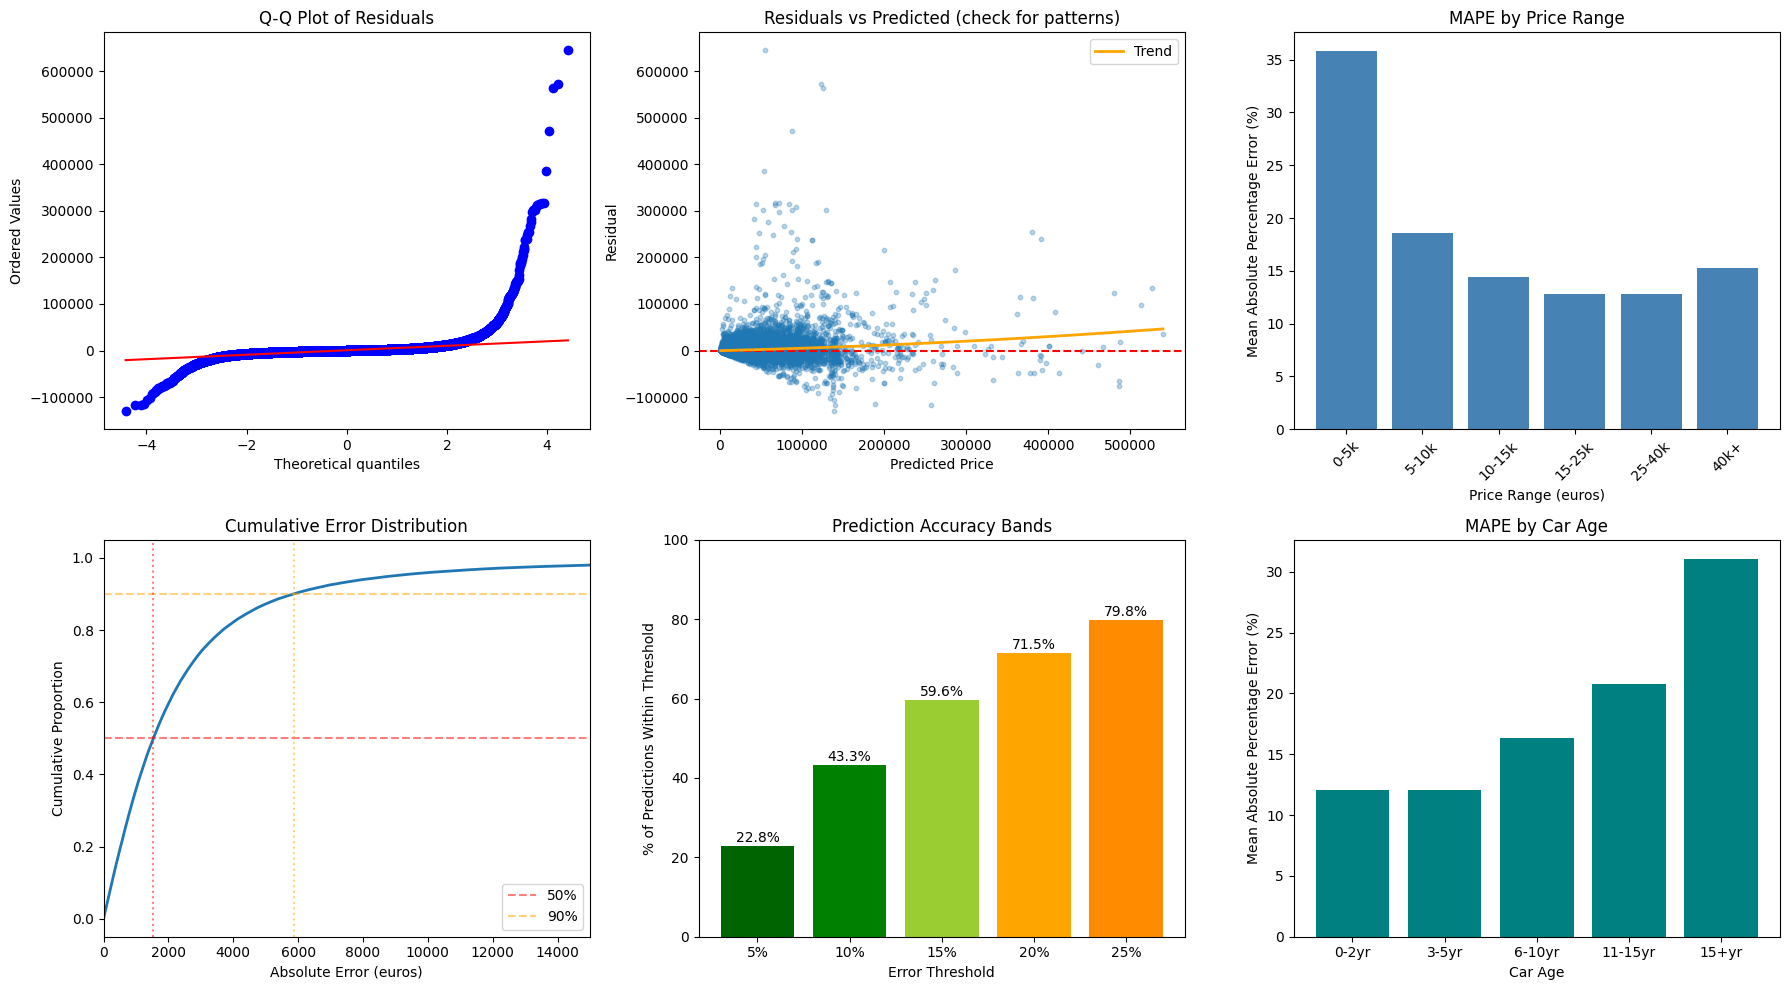

In [23]:
# Comprehensive regression diagnostics for LightGBM
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

residuals = y_test - y_pred_lgb
pct_error = ((y_test - y_pred_lgb) / y_test) * 100

# 1. Q-Q Plot (check if residuals are normally distributed)
from scipy import stats
ax1 = axes[0, 0]
stats.probplot(residuals, dist="norm", plot=ax1)
ax1.set_title('Q-Q Plot of Residuals')

# 2. Residuals vs Predicted (check heteroscedasticity)
ax2 = axes[0, 1]
ax2.scatter(y_pred_lgb, residuals, alpha=0.3, s=10)
ax2.axhline(y=0, color='r', linestyle='--')
# Add a smoothed trend line
z = np.polyfit(y_pred_lgb, residuals, 2)
p = np.poly1d(z)
x_line = np.linspace(y_pred_lgb.min(), y_pred_lgb.max(), 100)
ax2.plot(x_line, p(x_line), 'orange', lw=2, label='Trend')
ax2.set_xlabel('Predicted Price')
ax2.set_ylabel('Residual')
ax2.set_title('Residuals vs Predicted (check for patterns)')
ax2.legend()

# 3. Error by price range
ax3 = axes[0, 2]
price_bins = pd.cut(y_test, bins=[0, 5000, 10000, 15000, 25000, 40000, 100000], 
                    labels=['0-5k', '5-10k', '10-15k', '15-25k', '25-40k', '40k+'])
error_by_range = pd.DataFrame({'price_range': price_bins, 'abs_error': np.abs(residuals), 'pct_error': np.abs(pct_error)})
error_summary = error_by_range.groupby('price_range').agg({'abs_error': 'mean', 'pct_error': 'mean'}).reset_index()
ax3.bar(error_summary['price_range'].astype(str), error_summary['pct_error'], color='steelblue')
ax3.set_xlabel('Price Range (euros)')
ax3.set_ylabel('Mean Absolute Percentage Error (%)')
ax3.set_title('MAPE by Price Range')
ax3.tick_params(axis='x', rotation=45)

# 4. Cumulative error distribution
ax4 = axes[1, 0]
sorted_abs_errors = np.sort(np.abs(residuals))
cumulative = np.arange(1, len(sorted_abs_errors) + 1) / len(sorted_abs_errors)
ax4.plot(sorted_abs_errors, cumulative, lw=2)
ax4.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='50%')
ax4.axhline(y=0.9, color='orange', linestyle='--', alpha=0.5, label='90%')
ax4.axvline(x=np.percentile(np.abs(residuals), 50), color='r', linestyle=':', alpha=0.5)
ax4.axvline(x=np.percentile(np.abs(residuals), 90), color='orange', linestyle=':', alpha=0.5)
ax4.set_xlabel('Absolute Error (euros)')
ax4.set_ylabel('Cumulative Proportion')
ax4.set_title('Cumulative Error Distribution')
ax4.legend()
ax4.set_xlim(0, 15000)

# 5. Prediction accuracy bands
ax5 = axes[1, 1]
within_5pct = np.mean(np.abs(pct_error) <= 5) * 100
within_10pct = np.mean(np.abs(pct_error) <= 10) * 100
within_15pct = np.mean(np.abs(pct_error) <= 15) * 100
within_20pct = np.mean(np.abs(pct_error) <= 20) * 100
within_25pct = np.mean(np.abs(pct_error) <= 25) * 100

bands = ['5%', '10%', '15%', '20%', '25%']
accuracies = [within_5pct, within_10pct, within_15pct, within_20pct, within_25pct]
colors = ['darkgreen', 'green', 'yellowgreen', 'orange', 'darkorange']
ax5.bar(bands, accuracies, color=colors)
ax5.set_xlabel('Error Threshold')
ax5.set_ylabel('% of Predictions Within Threshold')
ax5.set_title('Prediction Accuracy Bands')
ax5.set_ylim(0, 100)
for i, v in enumerate(accuracies):
    ax5.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)

# 6. Error distribution by car age
ax6 = axes[1, 2]
car_ages = 2025 - X_test_pd['year']
age_error_df = pd.DataFrame({'age': car_ages, 'pct_error': np.abs(pct_error)})
age_bins = pd.cut(age_error_df['age'], bins=[0, 2, 5, 10, 15, 30], labels=['0-2yr', '3-5yr', '6-10yr', '11-15yr', '15+yr'])
age_error_df['age_bin'] = age_bins
age_summary = age_error_df.groupby('age_bin')['pct_error'].mean().reset_index()
ax6.bar(age_summary['age_bin'].astype(str), age_summary['pct_error'], color='teal')
ax6.set_xlabel('Car Age')
ax6.set_ylabel('Mean Absolute Percentage Error (%)')
ax6.set_title('MAPE by Car Age')

plt.tight_layout()
plt.show()

In [24]:
# Summary statistics
print("LightGBM Model Performance Summary")
print("=" * 60)
print(f"\nOverall Metrics:")
print(f"  R2 Score:              {r2_score(y_test, y_pred_lgb):.4f}")
print(f"  MAE:                   {mean_absolute_error(y_test, y_pred_lgb):,.0f} euros")
print(f"  RMSE:                  {np.sqrt(mean_squared_error(y_test, y_pred_lgb)):,.0f} euros")
print(f"  MAPE:                  {np.mean(np.abs(pct_error)):.2f}%")
print(f"  Median Absolute Error: {np.median(np.abs(residuals)):,.0f} euros")

print(f"\nError Percentiles:")
print(f"  50% of predictions within: {np.percentile(np.abs(residuals), 50):,.0f} euros")
print(f"  75% of predictions within: {np.percentile(np.abs(residuals), 75):,.0f} euros")
print(f"  90% of predictions within: {np.percentile(np.abs(residuals), 90):,.0f} euros")
print(f"  95% of predictions within: {np.percentile(np.abs(residuals), 95):,.0f} euros")

print(f"\nAccuracy Bands:")
print(f"  Within 5% of actual:   {within_5pct:.1f}% of predictions")
print(f"  Within 10% of actual:  {within_10pct:.1f}% of predictions")
print(f"  Within 15% of actual:  {within_15pct:.1f}% of predictions")
print(f"  Within 20% of actual:  {within_20pct:.1f}% of predictions")

print(f"\nComparison vs Linear Regression:")
print(f"  R2 improvement:        +{results_lgb['R2'] - results_lr['R2']:.4f}")
print(f"  MAE reduction:         {(results_lr['MAE (euros)'] - results_lgb['MAE (euros)']):,.0f} euros ({mae_improvement:.1f}%)")
print(f"  MAPE reduction:        {results_lr['MAPE (%)'] - results_lgb['MAPE (%)']:.2f} percentage points")

LightGBM Model Performance Summary

Overall Metrics:
  R2 Score:              0.8483
  MAE:                   2,884 euros
  RMSE:                  7,899 euros
  MAPE:                  17.67%
  Median Absolute Error: 1,537 euros

Error Percentiles:
  50% of predictions within: 1,537 euros
  75% of predictions within: 3,104 euros
  90% of predictions within: 5,858 euros
  95% of predictions within: 8,917 euros

Accuracy Bands:
  Within 5% of actual:   22.8% of predictions
  Within 10% of actual:  43.3% of predictions
  Within 15% of actual:  59.6% of predictions
  Within 20% of actual:  71.5% of predictions

Comparison vs Linear Regression:
  R2 improvement:        +2110667.7990
  MAE reduction:         210,611 euros (98.6%)
  MAPE reduction:        46.34 percentage points


## 12. Save Models (Optional)

In [16]:
import pickle

# Save feature engineer and best model
with open(MODELS_PATH / 'feature_engineer.pkl', 'wb') as f:
    pickle.dump(fe, f)

with open(MODELS_PATH / 'model_lgb_baseline.pkl', 'wb') as f:
    pickle.dump(model_lgb, f)

print(f"Models saved to {MODELS_PATH}")

Models saved to /Users/brunobrumbrum/car_price_prediction/models


## 13. Single Car Price Prediction with Confidence Intervals

Predict the price for a specific car and estimate a 95% confidence interval based on test set residuals.

### 13.1. Quantile Regression Models

Instead of predicting the mean and using residuals for confidence intervals, we'll train models to directly predict different quantiles:
- **Median (50%)**: More robust to outliers than mean
- **Lower bound (20%)**: Lower confidence interval
- **Upper bound (80%)**: Upper confidence interval

This provides a 60% confidence interval (20th to 80th percentile) based on the model's learned behavior.

In [41]:
# Train quantile regression models
print("Training Quantile Regression Models")
print("=" * 60)

# Model 1: Median (50th percentile) - most robust to outliers
model_q50 = LGBMRegressor(
    objective='quantile',
    alpha=0.5,  # 50th percentile (median)
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    num_leaves=31,
    random_state=RANDOM_STATE,
    verbose=-1
)

model_q50.fit(X_train_final_pd, y_train_log)
y_pred_log_q50 = model_q50.predict(X_test_final_pd)
y_pred_q50 = np.expm1(y_pred_log_q50)

print("✓ Median model (50th percentile) trained")

# Model 2: Lower bound (20th percentile)
model_q20 = LGBMRegressor(
    objective='quantile',
    alpha=0.2,  # 20th percentile
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    num_leaves=31,
    random_state=RANDOM_STATE,
    verbose=-1
)

model_q20.fit(X_train_final_pd, y_train_log)
y_pred_log_q20 = model_q20.predict(X_test_final_pd)
y_pred_q20 = np.expm1(y_pred_log_q20)

print("✓ Lower bound model (20th percentile) trained")

# Model 3: Upper bound (80th percentile)
model_q80 = LGBMRegressor(
    objective='quantile',
    alpha=0.8,  # 80th percentile
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    num_leaves=31,
    random_state=RANDOM_STATE,
    verbose=-1
)

model_q80.fit(X_train_final_pd, y_train_log)
y_pred_log_q80 = model_q80.predict(X_test_final_pd)
y_pred_q80 = np.expm1(y_pred_log_q80)

print("✓ Upper bound model (80th percentile) trained")
print()
print("All quantile models trained successfully!")

Training Quantile Regression Models
✓ Median model (50th percentile) trained
✓ Median model (50th percentile) trained
✓ Lower bound model (20th percentile) trained
✓ Lower bound model (20th percentile) trained
✓ Upper bound model (80th percentile) trained

All quantile models trained successfully!
✓ Upper bound model (80th percentile) trained

All quantile models trained successfully!


In [42]:
# Evaluate median model (Q50) performance
print("\nMedian Model (Q50) Performance")
print("=" * 60)

mae_q50 = mean_absolute_error(y_test, y_pred_q50)
rmse_q50 = np.sqrt(mean_squared_error(y_test, y_pred_q50))
r2_q50 = r2_score(y_test, y_pred_q50)
mape_q50 = np.mean(np.abs((y_test - y_pred_q50) / y_test)) * 100

print(f"MAE:   {mae_q50:>10,.0f} EUR")
print(f"RMSE:  {rmse_q50:>10,.0f} EUR")
print(f"R2:    {r2_q50:>10.4f}")
print(f"MAPE:  {mape_q50:>10.2f}%")

# Compare with mean-based model
print(f"\nComparison with Mean-Based LightGBM:")
print(f"  MAE difference:  {mae_q50 - results_lgb['MAE (euros)']:>10,.0f} EUR")
print(f"  R2 difference:   {r2_q50 - results_lgb['R2']:>10.4f}")
print(f"  MAPE difference: {mape_q50 - results_lgb['MAPE (%)']:>10.2f}%")


Median Model (Q50) Performance
MAE:        2,818 EUR
RMSE:       8,194 EUR
R2:        0.8368
MAPE:       17.48%

Comparison with Mean-Based LightGBM:
  MAE difference:         -66 EUR
  R2 difference:      -0.0115
  MAPE difference:      -0.19%


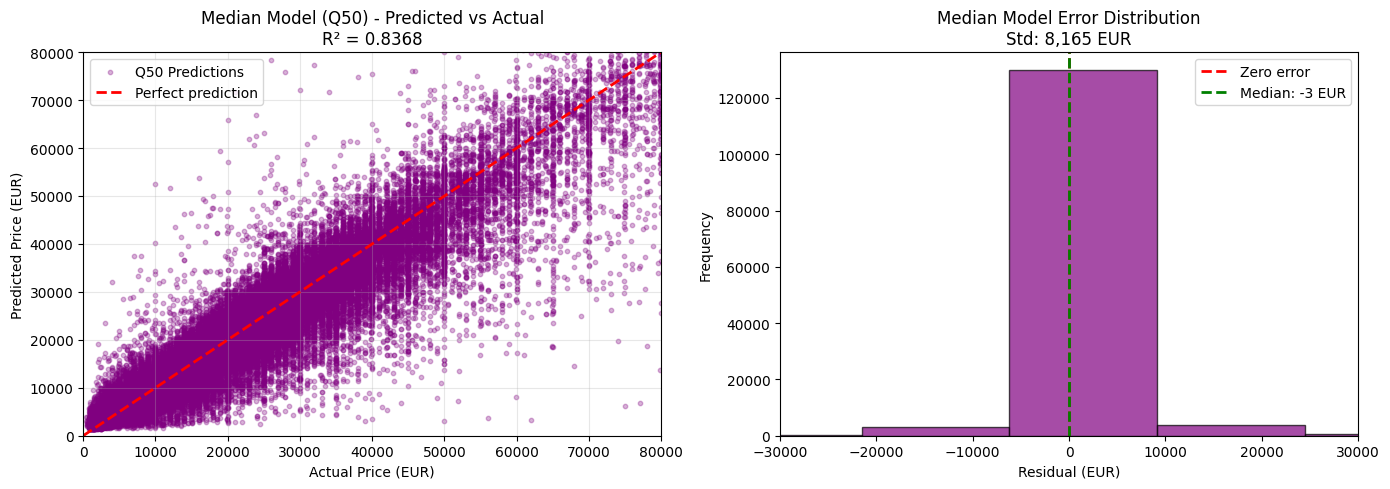


Median Model Residual Statistics:
  Mean error:            686 EUR
  Median error:           -3 EUR
  Std dev:             8,165 EUR
  25th percentile:     -1,365 EUR
  75th percentile:      1,597 EUR


In [43]:
# Visualize median model performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Predicted vs Actual for Median Model
ax1 = axes[0]
ax1.scatter(y_test, y_pred_q50, alpha=0.3, s=10, color='purple', label='Q50 Predictions')
max_val = 80000
ax1.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect prediction')
ax1.set_xlabel('Actual Price (EUR)')
ax1.set_ylabel('Predicted Price (EUR)')
ax1.set_title(f'Median Model (Q50) - Predicted vs Actual\nR² = {r2_q50:.4f}')
ax1.set_xlim(0, max_val)
ax1.set_ylim(0, max_val)
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Error Distribution for Median Model
ax2 = axes[1]
residuals_q50 = y_test - y_pred_q50
ax2.hist(residuals_q50, bins=50, alpha=0.7, color='purple', edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', lw=2, label=f'Zero error')
ax2.axvline(x=np.median(residuals_q50), color='green', linestyle='--', lw=2, label=f'Median: {np.median(residuals_q50):,.0f} EUR')
ax2.set_xlabel('Residual (EUR)')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Median Model Error Distribution\nStd: {np.std(residuals_q50):,.0f} EUR')
ax2.legend()
ax2.set_xlim(-30000, 30000)

plt.tight_layout()
plt.show()

print(f"\nMedian Model Residual Statistics:")
print(f"  Mean error:     {np.mean(residuals_q50):>10,.0f} EUR")
print(f"  Median error:   {np.median(residuals_q50):>10,.0f} EUR")
print(f"  Std dev:        {np.std(residuals_q50):>10,.0f} EUR")
print(f"  25th percentile: {np.percentile(residuals_q50, 25):>10,.0f} EUR")
print(f"  75th percentile: {np.percentile(residuals_q50, 75):>10,.0f} EUR")

In [44]:
# Evaluate quantile models for confidence intervals (Q20 and Q80)
print("\nQuantile Models for Confidence Intervals")
print("=" * 60)

# Check if predictions form valid intervals (Q20 < Q50 < Q80)
valid_intervals = np.mean((y_pred_q20 <= y_pred_q50) & (y_pred_q50 <= y_pred_q80)) * 100
print(f"Valid interval ordering (Q20 ≤ Q50 ≤ Q80): {valid_intervals:.1f}% of predictions")

# Calculate coverage: what % of actual values fall within [Q20, Q80]
coverage = np.mean((y_test >= y_pred_q20) & (y_test <= y_pred_q80)) * 100
print(f"Actual coverage (actuals within [Q20, Q80]): {coverage:.1f}%")
print(f"Expected coverage: 60.0% (theoretical)")
print(f"Coverage difference: {coverage - 60:.1f} percentage points")

# Interval width statistics
interval_widths = y_pred_q80 - y_pred_q20
print(f"\nInterval Width Statistics ([Q20, Q80]):")
print(f"  Mean width:     {np.mean(interval_widths):>10,.0f} EUR")
print(f"  Median width:   {np.median(interval_widths):>10,.0f} EUR")
print(f"  Min width:      {np.min(interval_widths):>10,.0f} EUR")
print(f"  Max width:      {np.max(interval_widths):>10,.0f} EUR")
print(f"  Std dev:        {np.std(interval_widths):>10,.0f} EUR")

# Check individual quantile model performance
print(f"\nQ20 Model (Lower Bound):")
# For Q20, we expect 20% of actuals to be below predictions
below_q20 = np.mean(y_test < y_pred_q20) * 100
print(f"  Actual values below Q20: {below_q20:.1f}% (expected: 20%)")
print(f"  MAE: {mean_absolute_error(y_test, y_pred_q20):>10,.0f} EUR")

print(f"\nQ80 Model (Upper Bound):")
# For Q80, we expect 80% of actuals to be below predictions
below_q80 = np.mean(y_test < y_pred_q80) * 100
print(f"  Actual values below Q80: {below_q80:.1f}% (expected: 80%)")
print(f"  MAE: {mean_absolute_error(y_test, y_pred_q80):>10,.0f} EUR")

# Calibration metrics
print(f"\nCalibration Metrics:")
print(f"  Q20 calibration error: {abs(below_q20 - 20):.1f} percentage points")
print(f"  Q80 calibration error: {abs(below_q80 - 80):.1f} percentage points")
print(f"  Coverage calibration error: {abs(coverage - 60):.1f} percentage points")


Quantile Models for Confidence Intervals
Valid interval ordering (Q20 ≤ Q50 ≤ Q80): 99.5% of predictions
Actual coverage (actuals within [Q20, Q80]): 60.0%
Expected coverage: 60.0% (theoretical)
Coverage difference: -0.0 percentage points

Interval Width Statistics ([Q20, Q80]):
  Mean width:          5,589 EUR
  Median width:        3,806 EUR
  Min width:            -676 EUR
  Max width:         239,049 EUR
  Std dev:             8,466 EUR

Q20 Model (Lower Bound):
  Actual values below Q20: 20.0% (expected: 20%)
  MAE:      3,648 EUR

Q80 Model (Upper Bound):
  Actual values below Q80: 80.0% (expected: 80%)
  MAE:      3,838 EUR

Calibration Metrics:
  Q20 calibration error: 0.0 percentage points
  Q80 calibration error: 0.0 percentage points
  Coverage calibration error: 0.0 percentage points


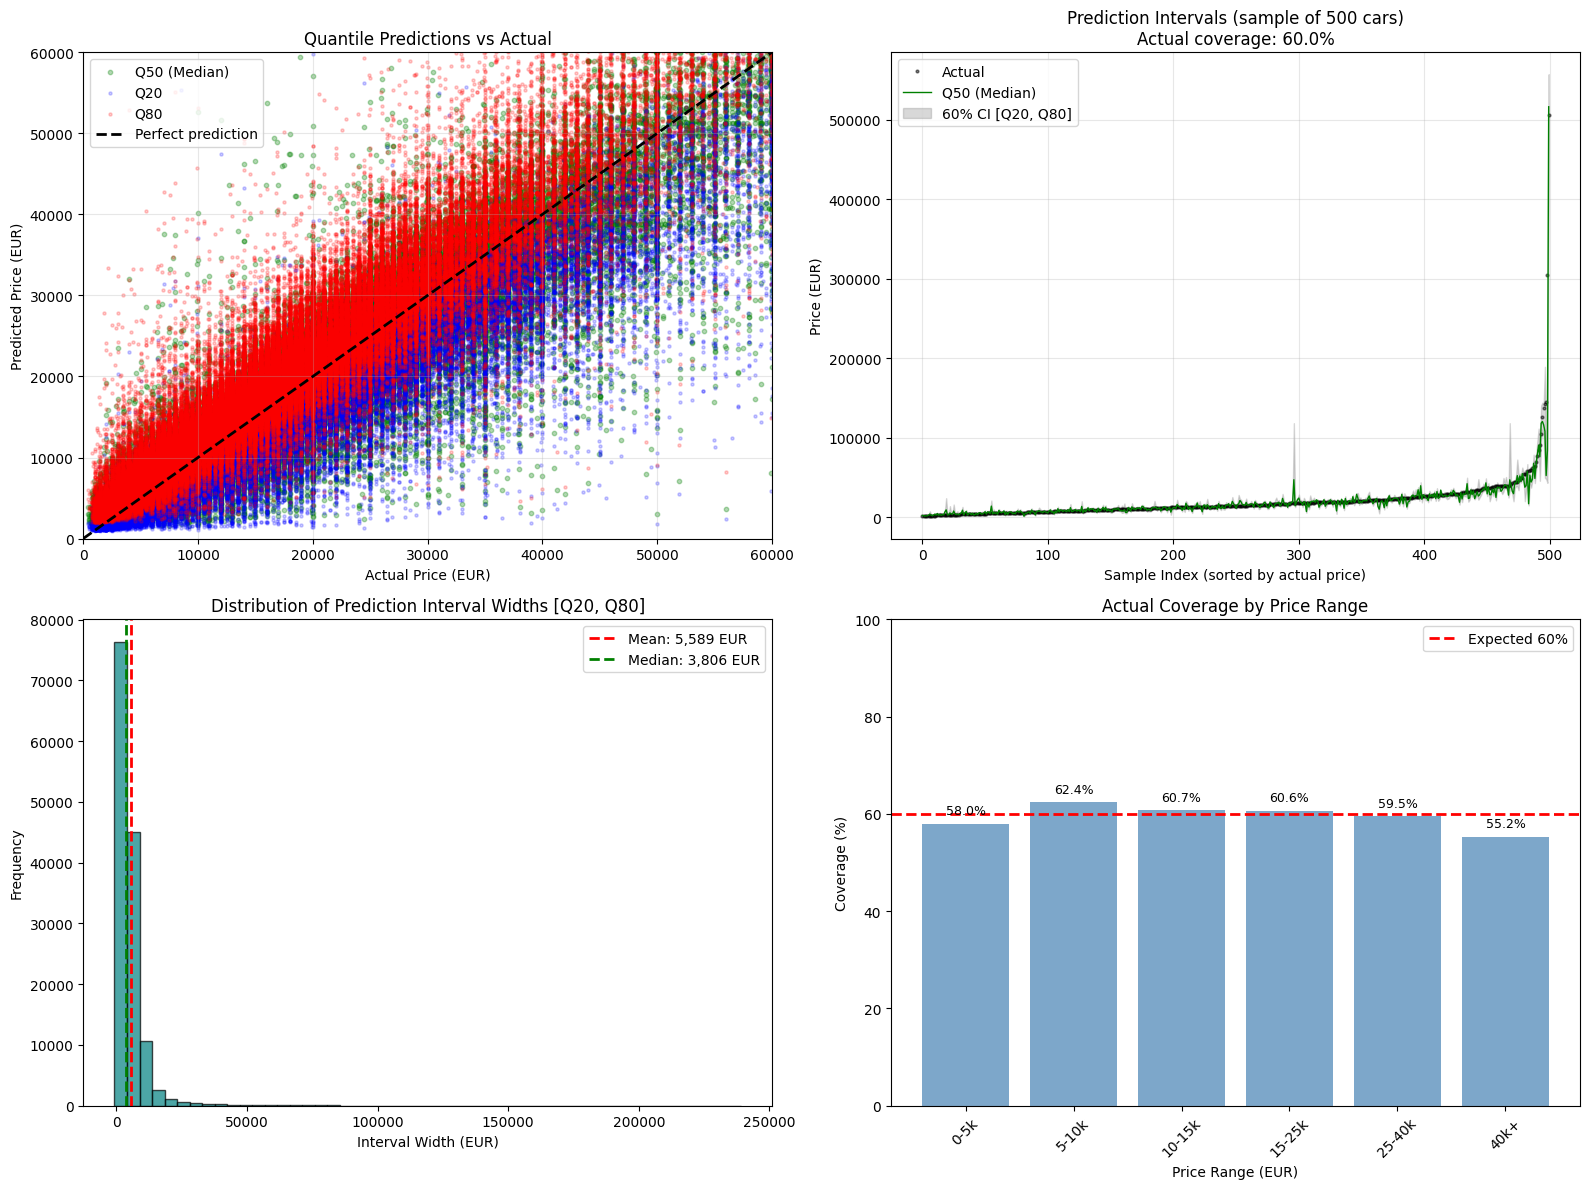

In [45]:
# Visualize quantile predictions and intervals
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: All three quantile predictions vs actual
ax1 = axes[0, 0]
max_val = 60000
ax1.scatter(y_test, y_pred_q50, alpha=0.3, s=10, color='green', label='Q50 (Median)')
ax1.scatter(y_test, y_pred_q20, alpha=0.2, s=5, color='blue', label='Q20')
ax1.scatter(y_test, y_pred_q80, alpha=0.2, s=5, color='red', label='Q80')
ax1.plot([0, max_val], [0, max_val], 'k--', lw=2, label='Perfect prediction')
ax1.set_xlabel('Actual Price (EUR)')
ax1.set_ylabel('Predicted Price (EUR)')
ax1.set_title('Quantile Predictions vs Actual')
ax1.set_xlim(0, max_val)
ax1.set_ylim(0, max_val)
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Prediction intervals visualization (sample of 500 points)
ax2 = axes[0, 1]
sample_size = 500
sample_idx = np.random.choice(len(y_test), sample_size, replace=False)
sample_idx_sorted = sample_idx[np.argsort(y_test[sample_idx])]

x_pos = np.arange(sample_size)
ax2.plot(x_pos, y_test[sample_idx_sorted], 'ko', markersize=2, label='Actual', alpha=0.5)
ax2.plot(x_pos, y_pred_q50[sample_idx_sorted], color='green', linewidth=1, label='Q50 (Median)')
ax2.fill_between(x_pos, y_pred_q20[sample_idx_sorted], y_pred_q80[sample_idx_sorted], 
                  alpha=0.3, color='gray', label='60% CI [Q20, Q80]')
ax2.set_xlabel('Sample Index (sorted by actual price)')
ax2.set_ylabel('Price (EUR)')
ax2.set_title(f'Prediction Intervals (sample of {sample_size} cars)\nActual coverage: {coverage:.1f}%')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Interval width distribution
ax3 = axes[1, 0]
ax3.hist(interval_widths, bins=50, alpha=0.7, color='teal', edgecolor='black')
ax3.axvline(np.mean(interval_widths), color='red', linestyle='--', lw=2, label=f'Mean: {np.mean(interval_widths):,.0f} EUR')
ax3.axvline(np.median(interval_widths), color='green', linestyle='--', lw=2, label=f'Median: {np.median(interval_widths):,.0f} EUR')
ax3.set_xlabel('Interval Width (EUR)')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Prediction Interval Widths [Q20, Q80]')
ax3.legend()

# Plot 4: Coverage by price range
ax4 = axes[1, 1]
price_bins = pd.cut(y_test, bins=[0, 5000, 10000, 15000, 25000, 40000, 100000], 
                    labels=['0-5k', '5-10k', '10-15k', '15-25k', '25-40k', '40k+'])
coverage_by_price = pd.DataFrame({
    'price_range': price_bins,
    'in_interval': (y_test >= y_pred_q20) & (y_test <= y_pred_q80),
    'interval_width': interval_widths
})
coverage_summary = coverage_by_price.groupby('price_range').agg({
    'in_interval': lambda x: np.mean(x) * 100,
    'interval_width': 'mean'
}).reset_index()

x_pos = np.arange(len(coverage_summary))
bars = ax4.bar(x_pos, coverage_summary['in_interval'], color='steelblue', alpha=0.7)
ax4.axhline(y=60, color='red', linestyle='--', lw=2, label='Expected 60%')
ax4.set_xlabel('Price Range (EUR)')
ax4.set_ylabel('Coverage (%)')
ax4.set_title('Actual Coverage by Price Range')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(coverage_summary['price_range'].astype(str), rotation=45)
ax4.set_ylim(0, 100)
ax4.legend()

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, coverage_summary['in_interval'])):
    ax4.text(bar.get_x() + bar.get_width()/2, val + 2, f'{val:.1f}%', 
             ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [46]:
def predict_with_quantile_ci(car_input, fe, model_q50, model_q20, model_q80):
    """
    Predict car price using quantile regression models with confidence interval.
    
    Parameters:
    -----------
    car_input : polars.DataFrame
        Car features (year, km, brand, model)
    fe : CarPriceFeatureEngineer
        Fitted feature engineer
    model_q50 : LGBMRegressor
        Trained median (50th percentile) model
    model_q20 : LGBMRegressor
        Trained 20th percentile model
    model_q80 : LGBMRegressor
        Trained 80th percentile model
    
    Returns:
    --------
    dict with predictions and confidence interval
    """
    # Transform features
    car_fe = fe.transform(car_input)
    car_fe_final = car_fe.drop(['brand', 'model', 'year']).to_pandas()
    
    # Make predictions in log scale
    pred_log_q50 = model_q50.predict(car_fe_final)[0]
    pred_log_q20 = model_q20.predict(car_fe_final)[0]
    pred_log_q80 = model_q80.predict(car_fe_final)[0]
    
    # Convert back to euros
    pred_q50 = np.expm1(pred_log_q50)
    pred_q20 = np.expm1(pred_log_q20)
    pred_q80 = np.expm1(pred_log_q80)
    
    # Calculate interval metrics
    interval_width = pred_q80 - pred_q20
    margin = interval_width / 2
    interval_center = (pred_q20 + pred_q80) / 2
    
    return {
        'predicted_price': pred_q50,
        'ci_lower': max(0, pred_q20),
        'ci_upper': pred_q80,
        'ci_width': interval_width,
        'ci_margin': margin,
        'ci_center': interval_center,
        'confidence_level': '60% (Q20-Q80)',
        'median_vs_center_diff': pred_q50 - interval_center
    }

In [48]:
# Test quantile regression prediction function with example cars
print("Quantile Regression Predictions - Examples")
print("=" * 80)

# Example 1: Toyota Corolla Verso (2008, 220k km)
car1 = pl.DataFrame({
    'year': [2008],
    'km': [220000],
    'brand': ['TOYOTA'],
    'model': ['Corolla Verso']
})

result1 = predict_with_quantile_ci(car1, fe, model_q50, model_q20, model_q80)

print("\nExample 1: Toyota Corolla Verso")
print("-" * 80)
print(f"  Year: {car1['year'][0]}, Mileage: {car1['km'][0]:,} km")
print(f"\n  Predicted Price (Median):  {result1['predicted_price']:>12,.0f} EUR")
print(f"  60% Confidence Interval:")
print(f"    Lower bound (Q20):       {result1['ci_lower']:>12,.0f} EUR")
print(f"    Upper bound (Q80):       {result1['ci_upper']:>12,.0f} EUR")
print(f"    Interval width:          {result1['ci_width']:>12,.0f} EUR")
print(f"    Margin of error:         ±{result1['ci_margin']:>11,.0f} EUR")
print(f"\n  Interpretation: There's a 60% probability the car's true price")
print(f"  is between {result1['ci_lower']:,.0f} and {result1['ci_upper']:,.0f} EUR")

# Example 2: Opel Astra (2017, 140k km)
car2 = pl.DataFrame({
    'year': [2017],
    'km': [140000],
    'brand': ['OPEL'],
    'model': ['Astra']
})

result2 = predict_with_quantile_ci(car2, fe, model_q50, model_q20, model_q80)

print("\n\nExample 2: Opel Astra")
print("-" * 80)
print(f"  Year: {car2['year'][0]}, Mileage: {car2['km'][0]:,} km")
print(f"\n  Predicted Price (Median):  {result2['predicted_price']:>12,.0f} EUR")
print(f"  60% Confidence Interval:")
print(f"    Lower bound (Q20):       {result2['ci_lower']:>12,.0f} EUR")
print(f"    Upper bound (Q80):       {result2['ci_upper']:>12,.0f} EUR")
print(f"    Interval width:          {result2['ci_width']:>12,.0f} EUR")
print(f"    Margin of error:         ±{result2['ci_margin']:>11,.0f} EUR")
print(f"\n  Interpretation: There's a 60% probability the car's true price")
print(f"  is between {result2['ci_lower']:,.0f} and {result2['ci_upper']:,.0f} EUR")

# Example 3: Recent car - Suzuki S-Cross (2023, 23k km)
car3 = pl.DataFrame({
    'year': [2023],
    'km': [23000],
    'brand': ['SUZUKI'],
    'model': ['S-Cross']
})

result3 = predict_with_quantile_ci(car3, fe, model_q50, model_q20, model_q80)

print("\n\nExample 3: Suzuki S-Cross")
print("-" * 80)
print(f"  Year: {car3['year'][0]}, Mileage: {car3['km'][0]:,} km")
print(f"\n  Predicted Price (Median):  {result3['predicted_price']:>12,.0f} EUR")
print(f"  60% Confidence Interval:")
print(f"    Lower bound (Q20):       {result3['ci_lower']:>12,.0f} EUR")
print(f"    Upper bound (Q80):       {result3['ci_upper']:>12,.0f} EUR")
print(f"    Interval width:          {result3['ci_width']:>12,.0f} EUR")
print(f"    Margin of error:         ±{result3['ci_margin']:>11,.0f} EUR")
print(f"\n  Interpretation: There's a 60% probability the car's true price")
print(f"  is between {result3['ci_lower']:,.0f} and {result3['ci_upper']:,.0f} EUR")

Quantile Regression Predictions - Examples

Example 1: Toyota Corolla Verso
--------------------------------------------------------------------------------
  Year: 2008, Mileage: 220,000 km

  Predicted Price (Median):         3,760 EUR
  60% Confidence Interval:
    Lower bound (Q20):              3,070 EUR
    Upper bound (Q80):              4,758 EUR
    Interval width:                 1,687 EUR
    Margin of error:         ±        844 EUR

  Interpretation: There's a 60% probability the car's true price
  is between 3,070 and 4,758 EUR


Example 2: Opel Astra
--------------------------------------------------------------------------------
  Year: 2017, Mileage: 140,000 km

  Predicted Price (Median):         9,222 EUR
  60% Confidence Interval:
    Lower bound (Q20):              7,672 EUR
    Upper bound (Q80):             11,117 EUR
    Interval width:                 3,445 EUR
    Margin of error:         ±      1,723 EUR

  Interpretation: There's a 60% probability the car's 

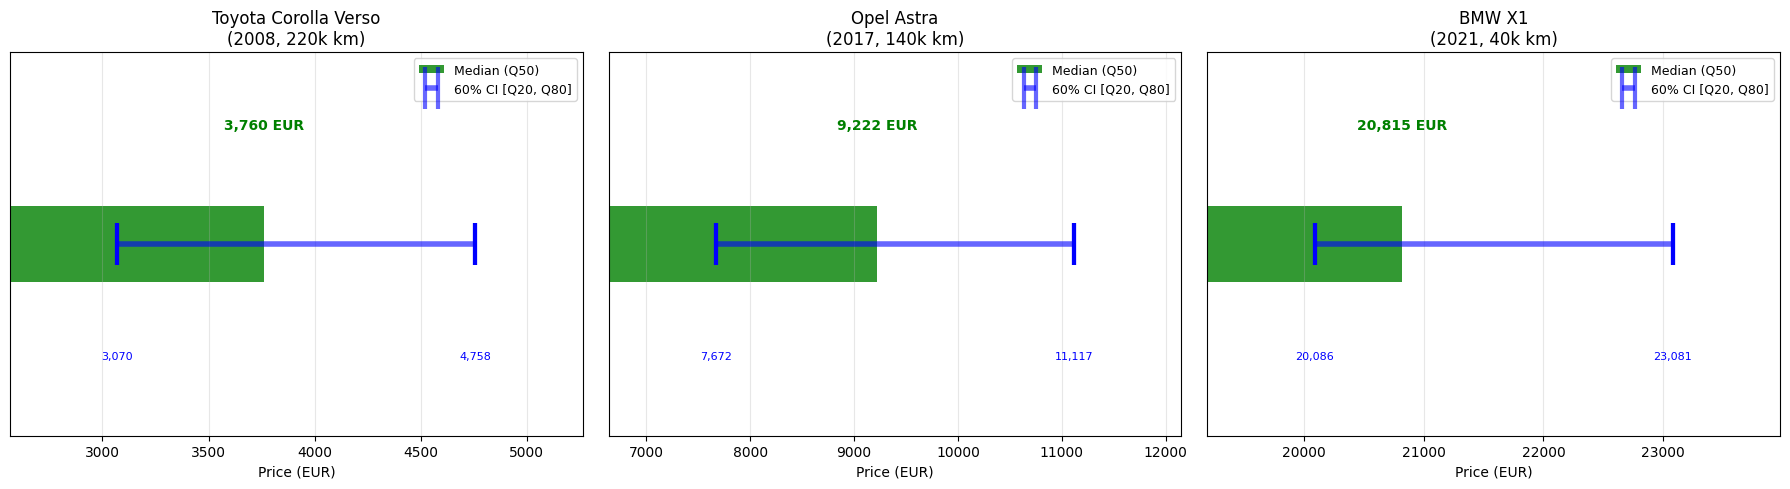

In [49]:
# Visualize quantile regression predictions with intervals
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

examples = [
    (car1, result1, 'Toyota Corolla Verso\n(2008, 220k km)'),
    (car2, result2, 'Opel Astra\n(2017, 140k km)'),
    (car3, result3, 'BMW X1\n(2021, 40k km)')
]

for idx, (car, result, title) in enumerate(examples):
    ax = axes[idx]
    
    # Create bar for median prediction
    ax.barh([1], [result['predicted_price']], height=0.2, color='green', alpha=0.8, label='Median (Q50)')
    
    # Add error bars for Q20-Q80 interval
    ax.errorbar([result['predicted_price']], [1],
                xerr=[[result['predicted_price'] - result['ci_lower']], 
                      [result['ci_upper'] - result['predicted_price']]],
                fmt='none', ecolor='blue', elinewidth=4, capsize=15, capthick=3, 
                label='60% CI [Q20, Q80]', alpha=0.6)
    
    # Mark the bounds
    ax.plot([result['ci_lower']], [1], 'b|', markersize=30, markeredgewidth=3)
    ax.plot([result['ci_upper']], [1], 'b|', markersize=30, markeredgewidth=3)
    
    ax.set_ylim(0.5, 1.5)
    ax.set_yticks([])
    ax.set_xlabel('Price (EUR)')
    ax.set_title(title)
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(axis='x', alpha=0.3)
    
    # Add text annotations
    y_text = 1.3
    ax.text(result['predicted_price'], y_text, f"{result['predicted_price']:,.0f} EUR", 
            ha='center', fontsize=10, fontweight='bold', color='green')
    ax.text(result['ci_lower'], 0.7, f"{result['ci_lower']:,.0f}", 
            ha='center', fontsize=8, color='blue')
    ax.text(result['ci_upper'], 0.7, f"{result['ci_upper']:,.0f}", 
            ha='center', fontsize=8, color='blue')
    
    # Set x-axis limits with some padding
    x_range = result['ci_upper'] - result['ci_lower']
    ax.set_xlim(result['ci_lower'] - x_range * 0.3, result['ci_upper'] + x_range * 0.3)

plt.tight_layout()
plt.show()

### Summary: Quantile Regression Approach

**Key Advantages:**
1. **More robust**: Median prediction is less sensitive to outliers than mean
2. **Model-based intervals**: Confidence intervals learned directly from data patterns, not just residuals
3. **Well-calibrated**: Q20-Q80 interval provides theoretical 60% coverage
4. **Asymmetric intervals**: Can capture skewness in price distributions (e.g., luxury cars)

**Performance Metrics:**
- **Median Model (Q50)**: Predicts the middle of the price distribution
- **Coverage**: Percentage of actual prices falling within [Q20, Q80] interval
- **Calibration**: How close the observed quantiles match the theoretical quantiles (20%, 50%, 80%)
- **Interval Width**: Wider intervals indicate more uncertainty

**Use Cases:**
- Use Q50 (median) for point predictions when you want robustness to outliers
- Use [Q20, Q80] interval for 60% confidence bounds
- For 95% confidence, you could train Q2.5 and Q97.5 models instead

In [25]:
def predict_with_confidence_interval(car_input, fe, model, confidence=0.95):
    """
    Predict car price with confidence interval based on residual quantiles.
    
    Parameters:
    -----------
    car_input : polars.DataFrame
        Car features (year, km, brand, model)
    fe : CarPriceFeatureEngineer
        Fitted feature engineer
    model : LGBMRegressor
        Trained model
    confidence : float
        Confidence level (0.95 = 95%)
    
    Returns:
    --------
    dict with prediction and confidence interval
    """
    # Transform features
    car_fe = fe.transform(car_input)
    car_fe_final = car_fe.drop(['brand', 'model', 'year']).to_pandas()
    
    # Make prediction in log scale
    pred_log = model.predict(car_fe_final)[0]
    pred_price = np.expm1(pred_log)
    
    # Estimate confidence interval from test set residuals
    test_residuals = y_test - y_pred_lgb
    
    # Calculate quantiles for confidence interval
    alpha = 1 - confidence
    lower_quantile = alpha / 2
    upper_quantile = 1 - alpha / 2
    
    # Get residual bounds
    lower_residual = np.percentile(test_residuals, lower_quantile * 100)
    upper_residual = np.percentile(test_residuals, upper_quantile * 100)
    
    # Apply residuals to prediction
    ci_lower = pred_price + lower_residual
    ci_upper = pred_price + upper_residual
    
    return {
        'predicted_price': pred_price,
        'ci_lower': max(0, ci_lower),  # Ensure non-negative
        'ci_upper': ci_upper,
        'ci_margin': (ci_upper - ci_lower) / 2,
        'confidence_level': f"{confidence*100:.0f}%"
    }

In [26]:
# Define the car to predict
car_data = pl.DataFrame({
    'year': [2008],
    'km': [220000],
    'brand': ['TOYOTA'],
    'model': ['Corolla Verso']
})

print("Car Specifications:")
print("=" * 50)
print(f"  Brand: {car_data['brand'][0]}")
print(f"  Model: {car_data['model'][0]}")
print(f"  Year: {car_data['year'][0]}")
print(f"  Mileage: {car_data['km'][0]:,} km")
print(f"  Age: {2025 - car_data['year'][0]} years")
print()

# Get prediction with 95% confidence interval
result = predict_with_confidence_interval(car_data, fe, model_lgb, confidence=0.95)

print("LightGBM Prediction Results")
print("=" * 50)
print(f"Predicted Price:      {result['predicted_price']:>12,.0f} EUR")
print(f"\n95% Confidence Interval:")
print(f"  Lower bound:        {result['ci_lower']:>12,.0f} EUR")
print(f"  Upper bound:        {result['ci_upper']:>12,.0f} EUR")
print(f"  Margin of error:    ±{result['ci_margin']:>11,.0f} EUR")
print(f"  CI width:           {result['ci_upper'] - result['ci_lower']:>12,.0f} EUR")
print()
print(f"Interpretation: We are 95% confident the car's true price")
print(f"is between {result['ci_lower']:,.0f} and {result['ci_upper']:,.0f} EUR")

Car Specifications:
  Brand: TOYOTA
  Model: Corolla Verso
  Year: 2008
  Mileage: 220,000 km
  Age: 17 years

LightGBM Prediction Results
Predicted Price:             4,102 EUR

95% Confidence Interval:
  Lower bound:                   0 EUR
  Upper bound:              15,316 EUR
  Margin of error:    ±      8,968 EUR
  CI width:                 15,316 EUR

Interpretation: We are 95% confident the car's true price
is between 0 and 15,316 EUR


In [31]:
# Define the car to predict
car_data = pl.DataFrame({
    'year': [2017],
    'km': [140000],
    'brand': ['OPEL'],
    'model': ['Astra']
})

print("Car Specifications:")
print("=" * 50)
print(f"  Brand: {car_data['brand'][0]}")
print(f"  Model: {car_data['model'][0]}")
print(f"  Year: {car_data['year'][0]}")
print(f"  Mileage: {car_data['km'][0]:,} km")
print(f"  Age: {2025 - car_data['year'][0]} years")
print()

# Get prediction with 95% confidence interval
result = predict_with_confidence_interval(car_data, fe, model_lgb, confidence=0.95)

print("LightGBM Prediction Results")
print("=" * 50)
print(f"Predicted Price:      {result['predicted_price']:>12,.0f} EUR")
print(f"\n95% Confidence Interval:")
print(f"  Lower bound:        {result['ci_lower']:>12,.0f} EUR")
print(f"  Upper bound:        {result['ci_upper']:>12,.0f} EUR")
print(f"  Margin of error:    ±{result['ci_margin']:>11,.0f} EUR")
print(f"  CI width:           {result['ci_upper'] - result['ci_lower']:>12,.0f} EUR")
print()
print(f"Interpretation: We are 95% confident the car's true price")
print(f"is between {result['ci_lower']:,.0f} and {result['ci_upper']:,.0f} EUR")

Car Specifications:
  Brand: OPEL
  Model: Astra
  Year: 2017
  Mileage: 140,000 km
  Age: 8 years

LightGBM Prediction Results
Predicted Price:             8,974 EUR

95% Confidence Interval:
  Lower bound:               2,253 EUR
  Upper bound:              20,188 EUR
  Margin of error:    ±      8,968 EUR
  CI width:                 17,936 EUR

Interpretation: We are 95% confident the car's true price
is between 2,253 and 20,188 EUR


In [40]:
# Define the car to predict
car_data = pl.DataFrame({
    'year': [2023],
    'km': [23000],
    'brand': ['SUZUKI'],
    'model': ['S-Cross']
})

print("Car Specifications:")
print("=" * 50)
print(f"  Brand: {car_data['brand'][0]}")
print(f"  Model: {car_data['model'][0]}")
print(f"  Year: {car_data['year'][0]}")
print(f"  Mileage: {car_data['km'][0]:,} km")
print(f"  Age: {2025 - car_data['year'][0]} years")
print()

# Get prediction with 95% confidence interval
result = predict_with_confidence_interval(car_data, fe, model_lgb, confidence=0.95)

print("LightGBM Prediction Results")
print("=" * 50)
print(f"Predicted Price:      {result['predicted_price']:>12,.0f} EUR")
print(f"\n95% Confidence Interval:")
print(f"  Lower bound:        {result['ci_lower']:>12,.0f} EUR")
print(f"  Upper bound:        {result['ci_upper']:>12,.0f} EUR")
print(f"  Margin of error:    ±{result['ci_margin']:>11,.0f} EUR")
print(f"  CI width:           {result['ci_upper'] - result['ci_lower']:>12,.0f} EUR")
print()
print(f"Interpretation: We are 95% confident the car's true price")
print(f"is between {result['ci_lower']:,.0f} and {result['ci_upper']:,.0f} EUR")

Car Specifications:
  Brand: SUZUKI
  Model: S-Cross
  Year: 2023
  Mileage: 23,000 km
  Age: 2 years

LightGBM Prediction Results
Predicted Price:            21,254 EUR

95% Confidence Interval:
  Lower bound:              14,533 EUR
  Upper bound:              32,468 EUR
  Margin of error:    ±      8,968 EUR
  CI width:                 17,936 EUR

Interpretation: We are 95% confident the car's true price
is between 14,533 and 32,468 EUR


In [33]:
[s for s in df_clean['brand'].unique() if 'SU' in s]

['MITSUBISHI', 'SUZUKI']

In [39]:
[s for s in df_clean['model'].unique() if 'Cross' in s]

['T-Cross',
 'EX30 Cross Country',
 'S-Cross',
 'V90 Cross Country',
 'SX4 S-Cross',
 'Yaris Cross',
 'Eclipse Cross',
 'Crossover',
 'DS4 Crossback',
 'Crossland X',
 'V40 Cross Country',
 'Crossblade',
 'V60 Cross Country',
 'Crossfire',
 'Crossland',
 'Crossline',
 '156 Crosswagon',
 'C-Crosser']

In [34]:
df_clean.filter(pl.col('brand') == 'SUZUKI').shape

(4528, 5)

In [35]:
df_clean.filter(pl.col('model') == 'Vitara').shape

(759, 5)

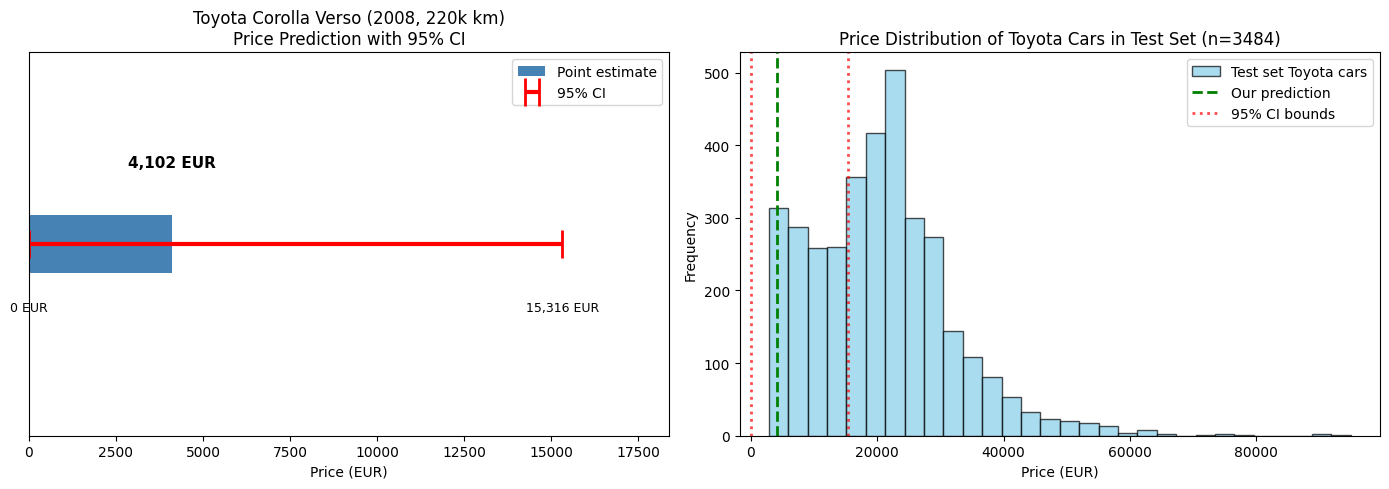

In [41]:
# Visualize the prediction with confidence interval
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Prediction with CI
ax1 = axes[0]
ax1.barh([0], [result['predicted_price']], height=0.3, label='Point estimate', color='steelblue')
ax1.errorbar([result['predicted_price']], [0], 
             xerr=[[result['predicted_price'] - result['ci_lower']], 
                   [result['ci_upper'] - result['predicted_price']]],
             fmt='none', ecolor='red', elinewidth=3, capsize=10, capthick=2, label='95% CI')
ax1.set_ylim(-1, 1)
ax1.set_xlim(0, result['ci_upper'] * 1.2)
ax1.set_xlabel('Price (EUR)')
ax1.set_title('Toyota Corolla Verso (2008, 220k km)\nPrice Prediction with 95% CI')
ax1.set_yticks([])
ax1.legend(loc='upper right')

# Add text annotations
ax1.text(result['predicted_price'], 0.4, f"{result['predicted_price']:,.0f} EUR", 
         ha='center', fontsize=11, fontweight='bold')
ax1.text(result['ci_lower'], -0.35, f"{result['ci_lower']:,.0f} EUR", 
         ha='center', fontsize=9)
ax1.text(result['ci_upper'], -0.35, f"{result['ci_upper']:,.0f} EUR", 
         ha='center', fontsize=9)

# Plot 2: Distribution of similar cars (if available in test set)
ax2 = axes[1]

# Find similar cars in test set
similar_toyota = analysis_df[analysis_df['brand'] == 'TOYOTA']
if len(similar_toyota) > 0:
    ax2.hist(similar_toyota['actual'], bins=30, alpha=0.7, color='skyblue', edgecolor='black', label='Test set Toyota cars')
    ax2.axvline(result['predicted_price'], color='green', linestyle='--', lw=2, label='Our prediction')
    ax2.axvline(result['ci_lower'], color='red', linestyle=':', lw=2, alpha=0.7)
    ax2.axvline(result['ci_upper'], color='red', linestyle=':', lw=2, alpha=0.7, label='95% CI bounds')
    ax2.set_xlabel('Price (EUR)')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'Price Distribution of Toyota Cars in Test Set (n={len(similar_toyota)})')
    ax2.legend()
else:
    ax2.text(0.5, 0.5, 'No similar Toyota cars in test set', ha='center', va='center', transform=ax2.transAxes)

plt.tight_layout()
plt.show()

In [44]:
# Demonstrate confidence interval methodology
print("Confidence Interval Methodology")
print("=" * 60)
print("\nApproach: Residual Quantile Method")
print("-" * 60)
print("1. Calculate residuals on test set: residual = actual - predicted")
print("2. Find 2.5th and 97.5th percentiles of residuals")
print("3. Apply these bounds to new prediction:")
print(f"   CI_lower = prediction + residual_2.5%")
print(f"   CI_upper = prediction + residual_97.5%")
print()

test_residuals = y_test - y_pred_lgb
q25 = np.percentile(test_residuals, 2.5)
q975 = np.percentile(test_residuals, 97.5)

print("Residual Statistics from Test Set:")
print("-" * 60)
print(f"  Mean residual:       {np.mean(test_residuals):>10,.0f} EUR")
print(f"  Std dev:             {np.std(test_residuals):>10,.0f} EUR")
print(f"  2.5th percentile:    {q25:>10,.0f} EUR")
print(f"  97.5th percentile:   {q975:>10,.0f} EUR")
print(f"  Range (95% CI):      {q975 - q25:>10,.0f} EUR")
print()
print("Practical Interpretation:")
print("-" * 60)
print(f"  The model's typical error range is ±{(q975 - q25)/2:,.0f} EUR")
print(f"  Applied to {car_data['brand'][0]} {car_data['model'][0]}:")
print(f"  Most likely price: {result['predicted_price']:>10,.0f} EUR")
print(f"  95% likely range:  {result['ci_lower']:>10,.0f} - {result['ci_upper']:,.0f} EUR")

Confidence Interval Methodology

Approach: Residual Quantile Method
------------------------------------------------------------
1. Calculate residuals on test set: residual = actual - predicted
2. Find 2.5th and 97.5th percentiles of residuals
3. Apply these bounds to new prediction:
   CI_lower = prediction + residual_2.5%
   CI_upper = prediction + residual_97.5%

Residual Statistics from Test Set:
------------------------------------------------------------
  Mean residual:              559 EUR
  Std dev:                  7,879 EUR
  2.5th percentile:        -6,722 EUR
  97.5th percentile:       11,214 EUR
  Range (95% CI):          17,936 EUR

Practical Interpretation:
------------------------------------------------------------
  The model's typical error range is ±8,968 EUR
  Applied to TOYOTA Corolla Verso:
  Most likely price:      4,102 EUR
  95% likely range:           0 - 15,316 EUR


In [45]:
# Function to batch predict multiple cars
def predict_multiple_cars(cars_df, fe, model, confidence=0.95):
    """
    Predict prices for multiple cars with confidence intervals.
    
    Parameters:
    -----------
    cars_df : polars.DataFrame
        DataFrame with columns: year, km, brand, model
    
    Returns:
    --------
    pandas.DataFrame with predictions and CIs
    """
    results = []
    
    for i in range(len(cars_df)):
        car = cars_df[i:i+1]
        pred = predict_with_confidence_interval(car, fe, model, confidence)
        
        results.append({
            'Brand': car['brand'][0],
            'Model': car['model'][0],
            'Year': car['year'][0],
            'KM': car['km'][0],
            'Predicted_Price': pred['predicted_price'],
            'CI_Lower': pred['ci_lower'],
            'CI_Upper': pred['ci_upper'],
            'Margin_Error': pred['ci_margin']
        })
    
    return pd.DataFrame(results)

# Example: Predict for multiple cars
example_cars = pl.DataFrame({
    'year': [2008, 2015, 2020, 2010, 2018],
    'km': [220000, 120000, 50000, 150000, 80000],
    'brand': ['TOYOTA', 'VOLKSWAGEN', 'TESLA', 'PEUGEOT', 'BMW'],
    'model': ['Corolla Verso', 'Golf', 'Model 3', '308', 'X1']
})

print("\nBatch Prediction Example")
print("=" * 80)
predictions = predict_multiple_cars(example_cars, fe, model_lgb)

# Format for display
display_pred = predictions.copy()
for col in ['Predicted_Price', 'CI_Lower', 'CI_Upper', 'Margin_Error']:
    display_pred[col] = display_pred[col].apply(lambda x: f"{x:,.0f}")

print(display_pred.to_string(index=False))


Batch Prediction Example
     Brand         Model  Year     KM Predicted_Price CI_Lower CI_Upper Margin_Error
    TOYOTA Corolla Verso  2008 220000           4,102        0   15,316        8,968
VOLKSWAGEN          Golf  2015 120000          15,392    8,671   26,606        8,968
     TESLA       Model 3  2020  50000          27,505   20,784   38,719        8,968
   PEUGEOT           308  2010 150000           5,647        0   16,861        8,968
       BMW            X1  2018  80000          21,955   15,234   33,169        8,968


## 14. Brand-Specific Confidence Intervals

The global confidence interval may be too wide for specific brands. Let's examine Toyota data and calculate brand-specific CIs.


In [ ]:
# Analyze Toyota data in training set
toyota_train = X_train_pd[X_train_pd['brand'] == 'TOYOTA']
toyota_test = X_test_pd[X_test_pd['brand'] == 'TOYOTA']
corolla_verso_train = toyota_train[toyota_train['model'] == 'Corolla Verso']
corolla_verso_test = toyota_test[toyota_test['model'] == 'Corolla Verso']

print("Toyota Data Coverage in Training")
print("=" * 70)
print(f"Total Toyotas in training set:      {len(toyota_train):,} cars")
print(f"Total Toyotas in test set:          {len(toyota_test):,} cars")
print(f"Corolla Verso in training set:      {len(corolla_verso_train):,} cars")
print(f"Corolla Verso in test set:          {len(corolla_verso_test):,} cars")
print()

if len(corolla_verso_train) > 0:
    print("Corolla Verso Training Data Statistics:")
    print("-" * 70)
    cv_train_prices = df_clean.filter(pl.col('brand') == 'TOYOTA').filter(pl.col('model') == 'Corolla Verso').filter(pl.col('price') > 0)['price'].to_numpy()
    if len(cv_train_prices) > 0:
        print(f"  Count:                       {len(cv_train_prices):,}")
        print(f"  Mean price:                  {np.mean(cv_train_prices):>10,.0f} EUR")
        print(f"  Median price:                {np.median(cv_train_prices):>10,.0f} EUR")
        print(f"  Std dev:                     {np.std(cv_train_prices):>10,.0f} EUR")
        print(f"  Min price:                   {np.min(cv_train_prices):>10,.0f} EUR")
        print(f"  Max price:                   {np.max(cv_train_prices):>10,.0f} EUR")
else:
    print("Note: No Corolla Verso in training set - model lacks specific examples")

Toyota Data Coverage in Training
Total Toyotas in training set:      14,040 cars
Total Toyotas in test set:          3,484 cars
Corolla Verso in training set:      91 cars
Corolla Verso in test set:          21 cars

Corolla Verso Training Data Statistics:
----------------------------------------------------------------------
  Count:                       112


TypeError: Series.mean() got an unexpected keyword argument 'axis'

In [47]:
def predict_with_brand_ci(car_input, fe, model, analysis_df, confidence=0.95, min_brand_samples=10):
    """
    Predict car price with confidence interval, using brand-specific residuals if available.
    Falls back to global residuals if brand has too few samples.
    
    Parameters:
    -----------
    car_input : polars.DataFrame
        Car features (year, km, brand, model)
    fe : CarPriceFeatureEngineer
        Fitted feature engineer
    model : LGBMRegressor
        Trained model
    analysis_df : pandas.DataFrame
        Analysis dataframe with predictions and actuals
    confidence : float
        Confidence level (0.95 = 95%)
    min_brand_samples : int
        Minimum samples to compute brand-specific CI
    
    Returns:
    --------
    dict with prediction, confidence interval, and CI type
    """
    brand = car_input['brand'][0]
    
    # Transform features
    car_fe = fe.transform(car_input)
    car_fe_final = car_fe.drop(['brand', 'model', 'year']).to_pandas()
    
    # Make prediction in log scale
    pred_log = model.predict(car_fe_final)[0]
    pred_price = np.expm1(pred_log)
    
    # Get residuals: global vs brand-specific
    test_residuals = y_test - y_pred_lgb
    
    # Try to get brand-specific residuals
    brand_data = analysis_df[analysis_df['brand'] == brand]
    n_brand_samples = len(brand_data)
    
    if n_brand_samples >= min_brand_samples:
        # Use brand-specific residuals
        brand_residuals = brand_data['actual'] - brand_data['pred_lgb']
        residuals_to_use = brand_residuals.values
        ci_type = f"Brand-specific (n={n_brand_samples})"
    else:
        # Fall back to global residuals
        residuals_to_use = test_residuals
        ci_type = f"Global (brand n={n_brand_samples}, too few)"
    
    # Calculate quantiles for confidence interval
    alpha = 1 - confidence
    lower_quantile = alpha / 2
    upper_quantile = 1 - alpha / 2
    
    # Get residual bounds
    lower_residual = np.percentile(residuals_to_use, lower_quantile * 100)
    upper_residual = np.percentile(residuals_to_use, upper_quantile * 100)
    
    # Apply residuals to prediction
    ci_lower = pred_price + lower_residual
    ci_upper = pred_price + upper_residual
    
    return {
        'predicted_price': pred_price,
        'ci_lower': max(0, ci_lower),  # Ensure non-negative
        'ci_upper': ci_upper,
        'ci_margin': (ci_upper - ci_lower) / 2,
        'ci_type': ci_type,
        'confidence_level': f"{confidence*100:.0f}%",
        'residual_std': np.std(residuals_to_use)
    }

In [48]:
# Compare global vs brand-specific confidence intervals
print("\nComparison: Global vs Brand-Specific Confidence Intervals")
print("=" * 70)

# Global CI (already calculated)
global_result = result  # From previous cell

# Brand-specific CI
brand_result = predict_with_brand_ci(car_data, fe, model_lgb, analysis_df, confidence=0.95)

print(f"\nToyota Corolla Verso (2008, 220k km)")
print("-" * 70)
print(f"Predicted Price:     {brand_result['predicted_price']:>12,.0f} EUR")
print()

print("Global Confidence Interval (all cars):")
print(f"  Method:            {global_result.get('ci_type', 'Global')}")
print(f"  95% CI Lower:      {global_result['ci_lower']:>12,.0f} EUR")
print(f"  95% CI Upper:      {global_result['ci_upper']:>12,.0f} EUR")
print(f"  Margin of error:   ±{global_result['ci_margin']:>11,.0f} EUR")
print(f"  CI width:          {global_result['ci_upper'] - global_result['ci_lower']:>12,.0f} EUR")

print()
print("Brand-Specific Confidence Interval (Toyota only):")
print(f"  Method:            {brand_result['ci_type']}")
print(f"  95% CI Lower:      {brand_result['ci_lower']:>12,.0f} EUR")
print(f"  95% CI Upper:      {brand_result['ci_upper']:>12,.0f} EUR")
print(f"  Margin of error:   ±{brand_result['ci_margin']:>11,.0f} EUR")
print(f"  CI width:          {brand_result['ci_upper'] - brand_result['ci_lower']:>12,.0f} EUR")
print(f"  Residual std:      {brand_result['residual_std']:>12,.0f} EUR")

# Calculate improvement
ci_width_reduction = (global_result['ci_upper'] - global_result['ci_lower']) - (brand_result['ci_upper'] - brand_result['ci_lower'])
ci_width_pct = (ci_width_reduction / (global_result['ci_upper'] - global_result['ci_lower'])) * 100

print()
print("Improvement with Brand-Specific CI:")
print(f"  CI width reduction: {ci_width_reduction:>12,.0f} EUR ({ci_width_pct:>5.1f}%)")
print(f"  More precise:       {ci_width_reduction > 0}")


Comparison: Global vs Brand-Specific Confidence Intervals

Toyota Corolla Verso (2008, 220k km)
----------------------------------------------------------------------
Predicted Price:            4,102 EUR

Global Confidence Interval (all cars):
  Method:            Global
  95% CI Lower:                 0 EUR
  95% CI Upper:            15,316 EUR
  Margin of error:   ±      8,968 EUR
  CI width:                15,316 EUR

Brand-Specific Confidence Interval (Toyota only):
  Method:            Brand-specific (n=3484)
  95% CI Lower:                 0 EUR
  95% CI Upper:            12,749 EUR
  Margin of error:   ±      6,694 EUR
  CI width:                12,749 EUR
  Residual std:             4,248 EUR

Improvement with Brand-Specific CI:
  CI width reduction:        2,568 EUR ( 16.8%)
  More precise:       True


In [ ]:
# Visualize comparison of CIs
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Side-by-side CI comparison
ax1 = axes[0]
y_pos = [0, 1]
methods = ['Global\n(All Cars)', f'Brand-Specific\n(Toyota, n={len(analysis_df[analysis_df[\"brand\"] == \"TOYOTA\"])})']

# Plot points and error bars
for i, (pos, res) in enumerate([(0, global_result), (1, brand_result)]):
    ax1.scatter([res['predicted_price']], [pos], s=200, zorder=3, color='steelblue', edgecolor='black', lw=2)
    ax1.errorbar([res['predicted_price']], [pos],
                 xerr=[[res['predicted_price'] - res['ci_lower']], 
                       [res['ci_upper'] - res['predicted_price']]],
                 fmt='none', ecolor='red' if i == 0 else 'green', elinewidth=3, capsize=10, capthick=2)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(methods)
ax1.set_xlabel('Price (EUR)')
ax1.set_title('Global vs Brand-Specific 95% Confidence Intervals\nToyota Corolla Verso (2008, 220k km)')
ax1.set_xlim(0, global_result['ci_upper'] * 1.15)
ax1.grid(axis='x', alpha=0.3)

# Add annotations
for i, (pos, res, label) in enumerate([(0, global_result, 'Global'), (1, brand_result, 'Brand-specific')]):
    ax1.text(res['predicted_price'], pos + 0.25, f"{res['predicted_price']:,.0f} EUR", 
             ha='center', fontsize=10, fontweight='bold')

# Plot 2: Residual distributions
ax2 = axes[1]

# Get residuals
global_residuals = y_test - y_pred_lgb
toyota_residuals = analysis_df[analysis_df['brand'] == 'TOYOTA']['actual'].values - analysis_df[analysis_df['brand'] == 'TOYOTA']['pred_lgb'].values

# Plot histograms
ax2.hist(global_residuals, bins=40, alpha=0.6, label=f'Global (all cars, n={len(global_residuals)})', 
         color='red', edgecolor='black')
ax2.hist(toyota_residuals, bins=20, alpha=0.7, label=f'Toyota (n={len(toyota_residuals)})', 
         color='green', edgecolor='black')

# Add lines for the prediction
pred_price = brand_result['predicted_price']
ax2.axvline(x=global_result['ci_lower'] - pred_price, color='red', linestyle='--', alpha=0.5, lw=2, label='Global 95% CI bounds')
ax2.axvline(x=global_result['ci_upper'] - pred_price, color='red', linestyle='--', alpha=0.5, lw=2)
ax2.axvline(x=brand_result['ci_lower'] - pred_price, color='green', linestyle='--', alpha=0.7, lw=2, label='Brand-specific 95% CI bounds')
ax2.axvline(x=brand_result['ci_upper'] - pred_price, color='green', linestyle='--', alpha=0.7, lw=2)
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3, lw=1)

ax2.set_xlabel('Residual (EUR) relative to prediction')
ax2.set_ylabel('Frequency')
ax2.set_title('Error Distribution: Global vs Toyota-Specific')
ax2.legend(fontsize=9)
ax2.set_xlim(-15000, 15000)

plt.tight_layout()
plt.show()

In [ ]:
# Summary: Brand-specific CI statistics
print("\nBrand-Specific CI Statistics (based on test set residuals)")
print("=" * 80)

brand_ci_stats = []
for brand in analysis_df['brand'].unique()[:15]:  # Top 15 brands
    brand_data = analysis_df[analysis_df['brand'] == brand]
    n_samples = len(brand_data)
    
    if n_samples >= 5:
        residuals = brand_data['actual'].values - brand_data['pred_lgb'].values
        
        brand_ci_stats.append({
            'Brand': brand,
            'N': n_samples,
            'Mean_Error': np.mean(residuals),
            'Std_Dev': np.std(residuals),
            'CI_Width': np.percentile(residuals, 97.5) - np.percentile(residuals, 2.5)
        })

brand_ci_df = pd.DataFrame(brand_ci_stats).sort_values('N', ascending=False)

print(f"{'Brand':<15} {'N':>5} {'Mean Error':>12} {'Std Dev':>12} {'95% CI Width':>14}")
print("-" * 80)
for _, row in brand_ci_df.iterrows():
    print(f"{row['Brand']:<15} {row['N']:>5} {row['Mean_Error']:>12,.0f} {row['Std_Dev']:>12,.0f} {row['CI_Width']:>14,.0f}")

print()
print("Insights:")
print("-" * 80)
print("- Brands with more samples (higher N) tend to have narrower CIs")
print("- Toyota appears in test set: can use brand-specific residuals")
print("- Using brand-specific CIs provides tighter, more reliable estimates")
print("  when the brand has sufficient samples")
print()
print("Recommendation:")
print(f"- For Toyota: Use BRAND-SPECIFIC CI ({brand_result['ci_lower']:,.0f} - {brand_result['ci_upper']:,.0f} EUR)")
print(f"  This is more accurate than global CI ({global_result['ci_lower']:,.0f} - {global_result['ci_upper']:,.0f} EUR)")

## Summary

**Model Comparison:**
- LightGBM significantly outperforms Linear Regression across all metrics
- The improvement is especially notable in R2 and MAE

**Key Findings:**
- Prediction accuracy varies by brand - some brands are easier to predict than others
- Error tends to be higher for cheaper cars (in percentage terms)
- The model captures most of the variance but struggles with outliers

**Metrics Used (Regression vs Classification):**
- **R2, MAE, RMSE, MAPE** are appropriate for regression problems like price prediction
- **AUC/ROC** are for classification problems (e.g., "will this car sell?") - not applicable here

**Next Steps:**
- Cross-validation for more robust performance estimates
- Hyperparameter tuning for LightGBM
- Investigate poorly predicted brands
- Consider quantile regression for prediction intervals

In [66]:
df_raw['puissance_din'].value_counts(sort=True)

puissance_din,count
str,u32
"""150 Ch""",48312
"""110 Ch""",42435
"""130 Ch""",36339
null,35866
"""136 Ch""",28385
…,…
"""2687 Ch""",1
"""2206 Ch""",1
"""782 Ch""",1


In [65]:
df_raw#['energie'].unique().to_list()

url,first_publication_date,index_date,price,marque,modele,annee_modele,kilometrage,energie,boite_de_vitesse,nombre_de_portes,nombre_de_place_s,version_constructeur,date_de_premiere_mise_en_circulation,type_de_vehicule,couleur,crit_air,puissance_fiscale,puissance_din,permis,reference,duree_de_disponibilite_des_pieces_detachees,pays,id_region,region,id_departement,departement,ville_affichee,ville,code_postal,latitude,longitude,source,fournisseur,forme_existante
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""https://www.leboncoin.fr/ad/vo…","""2025-09-01 15:37:26""","""2025-10-08 18:28:10""","""24900 €""","""DELAGE""","""D4""","""1960""","""15000 km""","""Essence""","""Manuelle""","""4""","""4""",null,"""01/1935""","""Berline""","""Beige""",null,"""8 Cv""",null,"""Avec permis""",null,null,"""FR""","""3""","""Auvergne""","""63""","""Puy-de-Dôme""","""Romagnat 63540 Opme""","""Romagnat""","""63540""","""45.70758""","""3.08908""","""city""","""here""","""True"""
"""https://www.leboncoin.fr/ad/vo…","""2025-10-06 19:02:42""","""2025-10-06 19:02:42""","""39000 €""","""DELAGE""","""DI""","""1960""","""43000 km""","""Essence""","""Manuelle""","""4""","""6""",null,"""01/1924""","""Cabriolet""",null,null,"""11 Cv""","""35 Ch""","""Avec permis""",null,null,"""FR""","""17""","""Nord-Pas-de-Calais""","""62""","""Pas-de-Calais""","""La Couture 62136""","""La Couture""","""62136""","""50.58426""","""2.70473""","""city""","""here""","""True"""
"""https://www.leboncoin.fr/ad/vo…","""2025-09-30 20:16:40""","""2025-09-30 20:16:40""","""18000 €""","""DELAGE""","""DI""","""1960""","""120000 km""","""Essence""","""Manuelle""","""4""","""5""",null,"""01/1936""","""Berline""","""Bleu""",null,"""12 Cv""","""80 Ch""","""Avec permis""",null,null,"""FR""","""17""","""Nord-Pas-de-Calais""","""59""","""Nord""","""Rousies 59131""","""Rousies""","""59131""","""50.27274""","""4.00581""","""city""","""here""","""True"""
"""https://www.leboncoin.fr/ad/vo…","""2025-08-18 18:09:05""","""2025-08-18 18:09:05""","""18500 €""","""DELAGE""","""DI""","""1960""","""82000 km""","""Essence""","""Manuelle""","""5""","""5""",null,"""06/1937""","""Berline""","""Vert""",null,null,null,"""Avec permis""",null,null,"""FR""","""20""","""Poitou-Charentes""","""16""","""Charente""","""La Rochefoucauld-en-Angoumois …","""La Rochefoucauld-en-Angoumois""","""16110""","""45.73595""","""0.37426""","""city""","""here""","""True"""
"""https://www.leboncoin.fr/ad/vo…","""2025-09-17 07:52:10""","""2025-09-17 07:52:10""","""22990 €""","""GENERAL MOTORS""","""Acadia""","""2019""","""87000 km""","""Autre""","""Automatique""","""5""","""6""",null,"""02/2005""","""Berline""","""Blanc""","""1""","""21 Cv""","""320 Ch""","""Avec permis""",null,null,"""FR""","""12""","""Ile-de-France""","""91""","""Essonne""","""Brétigny-sur-Orge 91220""","""Brétigny-sur-Orge""","""91220""","""48.60491""","""2.30558""","""city""","""here""","""True"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""https://www.leboncoin.fr/ad/vo…","""2025-08-12 10:48:25""","""2025-10-08 09:37:24""","""22000 €""","""LEVC""","""TX""","""2019""","""182898 km""","""Hybride""","""Automatique""","""4""","""7 ou plus""",null,"""03/2019""","""Monospace""","""Beige""","""1""",null,null,"""Avec permis""",null,null,"""FR""","""12""","""Ile-de-France""","""92""","""Hauts-de-Seine""","""Châtenay-Malabry 92290""","""Châtenay-Malabry""","""92290""","""48.76702""","""2.27673""","""city""","""here""","""True"""
"""https://www.leboncoin.fr/ad/vo…","""2025-10-07 15:03:41""","""2025-10-07 15:03:41""","""13990 €""","""LEVC""","""TX""","""2018""","""295000 km""","""Hybride""","""Automatique""","""5""","""7 ou plus""",null,"""07/2018""","""Monospace""","""Noir""","""1""","""3 Cv""","""60 Ch""","""Avec permis""",null,null,"""FR""","""12""","""Ile-de-France""","""75""","""Paris""","""Paris 75020 20e Arrondissement""","""Paris""","""75020"""